In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 


import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/Predict_Future_Sales/'

items = pd.read_csv(PATH+'items.csv')
item_categories = pd.read_csv(PATH+'item_categories.csv')
shops = pd.read_csv(PATH+'shops.csv')
sales_train = pd.read_csv(PATH+'sales_train.csv')

## For this new attempt, I'll focus on predicting the number of monthly sales per categories 

### Data pre-processing

In [5]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [6]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

### First, merge the two tables to get sales and item category in the same DataFrame

In [7]:
df = pd.merge(sales_train, items, how = 'left', left_on = 'item_id', right_on = 'item_id')
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                                  item_name  item_category_id  
0                         ЯВЛЕНИЕ 2012 (BD)                37  
1  DEEP PURPLE  The House Of Blue Light  LP                58  
2  DEEP PURPLE  The House Of Blue Light  LP                58  
3  DEEP PURPLE  Who Do You Think We Are  LP                58  
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56

In [8]:
df['date_'] = [datetime.strptime(date,"%d.%m.%Y") for date in df['date']]

In [9]:
df = df[['date_block_num','item_cnt_day','item_category_id']].groupby(['date_block_num','item_category_id']).sum()

In [10]:
df = df.reset_index()
df = df.pivot(index = 'date_block_num', columns = 'item_category_id', values = 'item_cnt_day')

In [ ]:
df

item_category_id   0    1       2       3      4      5       6       7   \
date_block_num                                                             
0                 1.0  1.0  1390.0   440.0  251.0  623.0   870.0     NaN   
1                 1.0  1.0  1190.0   302.0  220.0  358.0   668.0     NaN   
2                 NaN  NaN  1025.0   293.0  226.0  354.0   646.0     NaN   
3                 1.0  NaN   646.0   202.0  160.0  275.0   465.0     NaN   
4                 NaN  NaN   596.0   146.0  175.0  281.0   441.0     NaN   
5                 NaN  NaN   667.0   150.0  176.0  329.0   502.0     NaN   
6                 NaN  NaN   618.0   233.0  179.0  355.0   622.0     NaN   
7                 NaN  NaN   674.0   300.0  140.0  299.0   637.0     NaN   
8                 NaN  NaN   792.0   383.0   86.0  289.0   729.0     NaN   
9                 NaN  NaN   790.0   391.0   89.0  257.0  1016.0     NaN   
10                NaN  NaN   759.0   744.0   83.0  255.0   687.0     NaN   
11                NaN  NaN  2192.0  3004.0  112.0  650.0  1391.0     NaN   
12                NaN  NaN  1339.0  1180.0   96.0  279.0  1006.0     NaN   
13                NaN  NaN   742.0  1909.0   46.0  245.0   722.0     NaN   
14                NaN  NaN   645.0  1140.0   58.0  257.0   678.0     NaN   
15                NaN  NaN   508.0   669.0   35.0  183.0   507.0     NaN   
16                NaN  NaN   444.0   716.0   43.0  195.0   584.0     NaN   
17                NaN  NaN   487.0   855.0   54.0  174.0   700.0     NaN   
18                NaN  NaN   351.0   873.0   46.0  199.0   617.0     NaN   
19                NaN  NaN   342.0  1182.0   35.0  201.0   661.0     NaN   
20                NaN  NaN   355.0  1282.0   21.0  156.0   652.0   214.0   
21                NaN  NaN   372.0  1123.0   27.0  121.0   642.0   402.0   
22                NaN  NaN   357.0  1127.0    9.0  121.0   598.0   304.0   
23                NaN  NaN   573.0  2459.0   20.0  276.0  1139.0  1677.0   
24                NaN  NaN   370.0  1398.0   10.0  178.0   700.0   639.0   
25                NaN  NaN   307.0   834.0    2.0   85.0   400.0   220.0   
26                NaN  NaN   229.0   773.0    2.0   88.0   334.0   269.0   
27                NaN  NaN   170.0   746.0    2.0   67.0   266.0   244.0   
28                NaN  NaN   146.0   667.0    2.0   44.0   274.0   217.0   
29                NaN  NaN   104.0   559.0    1.0   51.0   319.0   238.0   
30                NaN  NaN   114.0   603.0    NaN   48.0   243.0   178.0   
31                NaN  NaN   132.0   975.0    1.0   45.0   277.0   307.0   
32                NaN  NaN    89.0  1090.0    NaN   31.0   237.0   244.0   
33                NaN  NaN    82.0  1059.0    NaN   44.0   242.0   205.0   

item_category_id      8       9   ...    74      75     76     77     78  \
date_block_num                    ...                                      
0                    NaN   149.0  ...   NaN  2980.0    NaN  481.0    NaN   
1                    NaN   159.0  ...   NaN  2670.0    NaN  519.0    NaN   
2                    NaN   211.0  ...   NaN  2523.0    NaN  431.0    NaN   
3                    NaN   138.0  ...   NaN  1998.0    NaN  394.0    NaN   
4                    NaN    95.0  ...   NaN  1568.0   95.0  272.0   37.0   
5                    NaN   124.0  ...   NaN  1442.0   98.0  256.0   82.0   
6                    NaN    83.0  ...   NaN  1519.0  100.0  291.0   55.0   
7                    NaN   124.0  ...   NaN  1639.0  105.0  233.0   36.0   
8                    NaN   141.0  ...   NaN  1846.0  121.0  131.0  149.0   
9                    NaN   253.0  ...   NaN  1873.0  112.0  119.0  111.0   
10                   NaN   976.0  ...   NaN  1912.0  186.0  140.0  190.0   
11                   NaN   362.0  ...   NaN  2252.0  189.0  120.0   98.0   
12                   NaN   158.0  ...   NaN  2034.0  184.0   82.0   80.0   
13                   NaN   419.0  ...   NaN  1687.0  121.0   54.0   98.0   
14                   NaN   772.0  ...   NaN  16

 ### By looking at data, we notice a lot of NA. We'll consider all NAs before the first non-NA value as an NA, but any NA after the first value will be consider as 0

In [11]:
# This fonction converts every missing values AFTER the first non-missing value to 0
def convert_nan_to_0(col):
  col = col = col.fillna(np.nan)
  for i in range(len(col)-1):
    if np.isnan(col[i+1]) and np.isnan(col[i]):
      col[i+1] = np.nan
    elif np.isnan(col[i+1]):
      col[i+1] = 0
  return col

In [12]:
df = df.apply(convert_nan_to_0, axis = 0)

<BarContainer object of 84 artists>

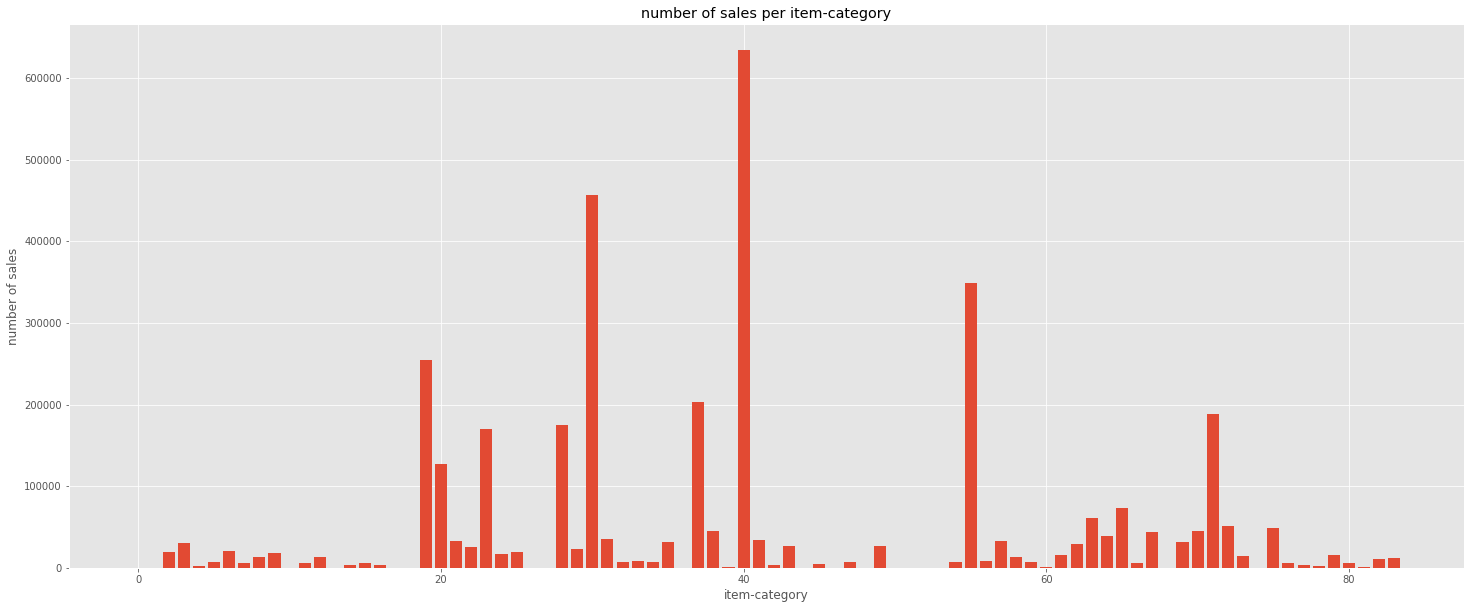

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(25, 10))
plt.title('number of sales per item-category')
plt.xlabel('item-category')
plt.ylabel('number of sales')
plt.bar(
    x=list(df.columns),
    height=[df[col].sum() for col in list(df.columns)]
)


### Creation of additional features

In [14]:
# Number of different items sold each month per category



In [16]:
df_ = pd.merge(sales_train, items, how = 'left', left_on = 'item_id', right_on = 'item_id')

In [17]:
df_.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                                  item_name  item_category_id  
0                         ЯВЛЕНИЕ 2012 (BD)                37  
1  DEEP PURPLE  The House Of Blue Light  LP                58  
2  DEEP PURPLE  The House Of Blue Light  LP                58  
3  DEEP PURPLE  Who Do You Think We Are  LP                58  
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56

In [18]:
range(1,13)[11]

12

In [19]:
df_['date_block_num']

0           0
1           0
2           0
3           0
4           0
           ..
2935844    33
2935845    33
2935846    33
2935847    33
2935848    33
Name: date_block_num, Length: 2935849, dtype: int64

In [20]:
# Month of year feature

df_['month_of_year'] = [range(1,13)[int(df_['date_block_num'][i]%12)] for i in range(len(df_))] 

In [21]:
unique_items_per_month = pd.DataFrame(df_[['date_block_num', 'item_id','item_category_id','month_of_year']].groupby(['item_category_id','date_block_num','month_of_year']).item_id.nunique())

In [22]:
unique_shops_per_month = pd.DataFrame(df_[['date_block_num','shop_id','item_category_id','month_of_year']].groupby(['item_category_id','date_block_num','month_of_year']).shop_id.nunique())

In [200]:
mean_price_per_month = pd.DataFrame(df_[['date_block_num','item_price','item_category_id','month_of_year']].groupby(['item_category_id','date_block_num','month_of_year']).item_price.mean())

In [24]:
t = list(set(df_['date_block_num']))
month = [range(1,13)[ti%12] for ti in t]

In [202]:
mean_price_per_month = mean_price_per_month.reset_index()
mean_price_per_month = mean_price_per_month.pivot(index = 'date_block_num', columns = 'item_category_id', values = 'item_price')

In [203]:
mean_price_per_month.head()

item_category_id     0      1            2           3           4   \
date_block_num                                                        
0                 148.0  148.0  2107.245400  477.099212  921.920168   
1                  93.0  283.0  2111.555408  472.987854  813.596117   
2                   NaN    NaN  2178.037218  500.243750  723.977962   
3                  22.4    NaN  2174.677857  490.977528  607.031447   
4                   NaN    NaN  2134.948822  509.209231  592.590857   

item_category_id           5            6   7   8            9   ...  74  \
date_block_num                                                   ...       
0                 1019.813183  1733.628012 NaN NaN   874.824731  ... NaN   
1                 1037.175429  1806.635149 NaN NaN  1034.253799  ... NaN   
2                 1146.963188  1817.772538 NaN NaN  1596.702056  ... NaN   
3                 1040.883333  1724.811845 NaN NaN  1058.579457  ... NaN   
4                  913.311722  1741.341769 NaN NaN  1067.040476  ... NaN   

item_category_id           75           76          77          78  \
date_block_num                                                       
0                 1606.036278          NaN  185.392291         NaN   
1                 1698.076751          NaN  181.521196         NaN   
2                 1739.289685          NaN  203.106700         NaN   
3                 1751.182631          NaN  194.266846         NaN   
4                 1773.542092  1010.432836  201.884000  219.714286   

item_category_id          79  80          81         82         83  
date_block_num                                                      
0                 484.876344 NaN  188.507143  31.175439  83.582225  
1                 809.975694 NaN  179.011905  30.931862  78.090309  
2                 855.884755 NaN  209.786517  34.627184  83.300372  
3                 829.436709 NaN  206.785714  32.337156  85.520000  
4                 417.784618 NaN  215.488095  31.480769  84.639394  

[5 rows x 84 columns]

In [27]:
mean_price_per_month = mean_price_per_month.apply(convert_nan_to_0, axis = 0)

In [ ]:
# We can't consider that we already 'know' the average price on the test set, so for the last 3 months, we'll replace them by their predicted values

In [ ]:
mean_price_per_month.iloc[:-4,:]

### Forecast on one new feature (one column)

#### Model init

In [101]:
X = pd.DataFrame()
X['t'] = t
X['month'] = month

In [171]:
y = pd.DataFrame(mean_price_per_month.iloc[:,7].fillna(0))

In [173]:
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 



#first 200 for training

X_train = X_ss[:29, :]
X_test = X_ss[29:, :]

y_train = y_mm[:29, :]
y_test = y_mm[29:, :] 



print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (29, 2) (29, 1)
Testing Shape (5, 2) (5, 1)


In [174]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([29, 1, 2]) torch.Size([29, 1])
Testing Shape torch.Size([5, 1, 2]) torch.Size([5, 1])


In [175]:
X_train_tensors_final.shape

torch.Size([29, 1, 2])

In [270]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
    
        self.fc_1 = nn.Linear(hidden_size, 150)
        self.fc = nn.Linear(150, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0),self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out


In [177]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes
    
    
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class


criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [178]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.15724
Epoch: 100, loss: 0.10692
Epoch: 200, loss: 0.03948
Epoch: 300, loss: 0.01939
Epoch: 400, loss: 0.01086
Epoch: 500, loss: 0.00905
Epoch: 600, loss: 0.00800
Epoch: 700, loss: 0.00740
Epoch: 800, loss: 0.00703
Epoch: 900, loss: 0.00675


In [179]:
df_X_ss = ss.transform(X) #old transformers
df_y_mm = mm.transform(y) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))  

In [180]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()   

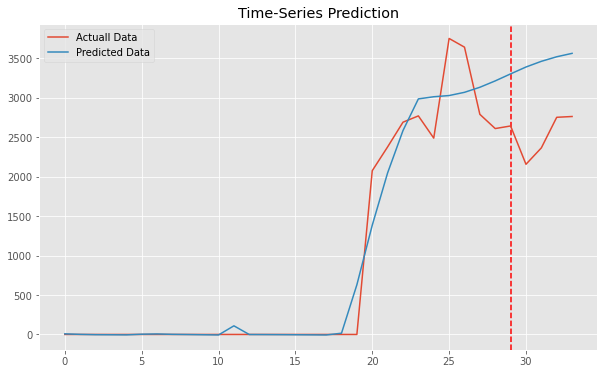

In [181]:
data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=29, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 
    

In [182]:
data_predict

array([[ 7.7189364e+00],
       [ 1.0897504e+00],
       [-2.8093894e+00],
       [-3.8360496e+00],
       [-5.1959858e+00],
       [ 3.0479288e+00],
       [ 6.3748760e+00],
       [ 1.3249778e+00],
       [-9.8447663e-01],
       [-3.5926609e+00],
       [-6.3278499e+00],
       [ 1.0940905e+02],
       [-8.5579473e-01],
       [-1.5779115e+00],
       [-2.5020509e+00],
       [-3.6484492e+00],
       [-5.0240374e+00],
       [-6.6094742e+00],
       [ 1.5741263e+01],
       [ 6.2993555e+02],
       [ 1.3846572e+03],
       [ 2.0481013e+03],
       [ 2.5844341e+03],
       [ 2.9854448e+03],
       [ 3.0126182e+03],
       [ 3.0279585e+03],
       [ 3.0688049e+03],
       [ 3.1327725e+03],
       [ 3.2136472e+03],
       [ 3.3024832e+03],
       [ 3.3895332e+03],
       [ 3.4616907e+03],
       [ 3.5194468e+03],
       [ 3.5626548e+03]], dtype=float32)

In [75]:
mean_price_per_month.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
           dtype='int64', name='item_category_id')

In [79]:
for category in list(mean_price_per_month.columns):
  
  y = pd.DataFrame(mean_price_per_month.iloc[:,category])

In [88]:
import tqdm as tq

In [94]:
mean_price_per_month.iloc[:,7].dropna()

date_block_num
20    2075.536932
21    2377.264706
22    2690.317726
23    2769.939342
24    2488.416313
25    3751.388389
26    3641.203704
27    2789.846822
28    2609.542654
29    2642.369955
30    2156.689213
31    2364.610929
32    2752.240596
33    2762.414573
Name: 7, dtype: float64

## Convert this one-shot process to make it loop over all lists

### First feature: mean_price_per_month

In [ ]:
  # Select list

mean_price_forecast = pd.DataFrame()

for category in tq.tqdm(list(mean_price_per_month.columns)):

    for layer in lstm1.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()

    y = pd.DataFrame(mean_price_per_month.iloc[:,category].fillna(0))

    X = pd.DataFrame()
    X['t'] = t
    X['month'] = month
    mm = MinMaxScaler()
    ss = StandardScaler()
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 



    #first 200 for training

    X_train = X_ss[:30, :]
    X_test = X_ss[30:, :]

    y_train = y_mm[:30, :]
    y_test = y_mm[30:, :] 

    # Convert to tensor

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    # Training 

    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    
      # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
    
        loss.backward() #calculates the loss of the loss function
    
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # Extract prediction

    df_X_ss = ss.transform(X) #old transformers
    df_y_mm = mm.transform(y) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))  


    train_predict = lstm1(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()   


    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)


    mean_price_forecast[category] = list(np.concatenate(dataY_plot)[:29]) +list(np.concatenate(data_predict)[29:])

### Now let's do the same for the two others additional features 

In [216]:
unique_items_per_month = pd.DataFrame(df_[['date_block_num', 'item_id','item_category_id','month_of_year']].groupby(['item_category_id','date_block_num','month_of_year']).item_id.nunique())

unique_items_per_month = unique_items_per_month.reset_index()
unique_items_per_month = unique_items_per_month.pivot(index = 'date_block_num', columns = 'item_category_id', values = 'item_id')


unique_items_per_month = unique_items_per_month.apply(convert_nan_to_0, axis = 0)

unique_items_per_month.head()

item_category_id   0    1     2    3     4     5     6   7   8    9   ...  74  \
date_block_num                                                        ...       
0                 1.0  1.0  37.0  2.0  11.0  27.0  19.0 NaN NaN  5.0  ... NaN   
1                 1.0  1.0  42.0  1.0  10.0  26.0  21.0 NaN NaN  5.0  ... NaN   
2                 0.0  0.0  39.0  2.0   9.0  24.0  19.0 NaN NaN  5.0  ... NaN   
3                 1.0  0.0  37.0  1.0   8.0  25.0  20.0 NaN NaN  4.0  ... NaN   
4                 0.0  0.0  39.0  2.0  10.0  24.0  23.0 NaN NaN  4.0  ... NaN   

item_category_id     75    76    77    78   79  80   81   82   83  
date_block_num                                                     
0                 100.0   NaN  43.0   NaN  1.0 NaN  6.0  7.0  6.0  
1                  99.0   NaN  53.0   NaN  1.0 NaN  3.0  6.0  8.0  
2                  96.0   NaN  36.0   NaN  1.0 NaN  6.0  6.0  4.0  
3                  93.0   NaN  50.0   NaN  1.0 NaN  4.0  7.0  5.0  
4                  86.0  21.0  41.0  27.0  1.0 NaN  4.0  6.0  5.0  

[5 rows x 84 columns]

In [ ]:
  # Select list

unique_items_forecast = pd.DataFrame()

for category in tq.tqdm(list(unique_items_per_month.columns)):

    for layer in lstm1.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()

    y = pd.DataFrame(unique_items_per_month.iloc[:,category].fillna(0))

    X = pd.DataFrame()
    X['t'] = t
    X['month'] = month
    mm = MinMaxScaler()
    ss = StandardScaler()
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 



    #first 200 for training

    X_train = X_ss[:30, :]
    X_test = X_ss[30:, :]

    y_train = y_mm[:30, :]
    y_test = y_mm[30:, :] 

    # Convert to tensor

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    # Training 

    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    
      # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
    
        loss.backward() #calculates the loss of the loss function
    
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # Extract prediction

    df_X_ss = ss.transform(X) #old transformers
    df_y_mm = mm.transform(y) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))  


    train_predict = lstm1(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()   


    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)


    unique_items_forecast[category] = list(np.concatenate(dataY_plot)[:29]) +list(np.concatenate(data_predict)[29:])

In [222]:
unique_shops_per_month = pd.DataFrame(df_[['date_block_num','shop_id','item_category_id','month_of_year']].groupby(['item_category_id','date_block_num','month_of_year']).shop_id.nunique())

unique_shops_per_month = unique_shops_per_month.reset_index()
unique_shops_per_month = unique_shops_per_month.pivot(index = 'date_block_num', columns = 'item_category_id', values = 'shop_id')


unique_shops_per_month = unique_shops_per_month.apply(convert_nan_to_0, axis = 0)


unique_shops_per_month.head()

item_category_id   0    1     2     3     4     5     6   7   8    9   ...  \
date_block_num                                                         ...   
0                 1.0  1.0  44.0  42.0  41.0  44.0  44.0 NaN NaN  1.0  ...   
1                 1.0  1.0  45.0  41.0  39.0  45.0  45.0 NaN NaN  1.0  ...   
2                 0.0  0.0  45.0  43.0  36.0  43.0  45.0 NaN NaN  1.0  ...   
3                 1.0  0.0  43.0  43.0  39.0  41.0  43.0 NaN NaN  1.0  ...   
4                 0.0  0.0  43.0  38.0  41.0  43.0  43.0 NaN NaN  1.0  ...   

item_category_id  74    75   76    77   78    79  80    81    82    83  
date_block_num                                                          
0                NaN  45.0  NaN  30.0  NaN  28.0 NaN  19.0  20.0  31.0  
1                NaN  46.0  NaN  33.0  NaN  34.0 NaN  15.0  20.0  31.0  
2                NaN  46.0  NaN  35.0  NaN  34.0 NaN  19.0  20.0  32.0  
3                NaN  45.0  NaN  34.0  NaN  26.0 NaN  19.0  20.0  31.0  
4                NaN  44.0  1.0  32.0  1.0  21.0 NaN  16.0  20.0  31.0  

[5 rows x 84 columns]

In [ ]:
  # Select list

unique_shops_forecast = pd.DataFrame()

for category in tq.tqdm(list(unique_shops_per_month.columns)):

    for layer in lstm1.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()

    y = pd.DataFrame(unique_shops_per_month.iloc[:,category].fillna(0))

    X = pd.DataFrame()
    X['t'] = t
    X['month'] = month
    mm = MinMaxScaler()
    ss = StandardScaler()
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 



    #first 200 for training

    X_train = X_ss[:30, :]
    X_test = X_ss[30:, :]

    y_train = y_mm[:30, :]
    y_test = y_mm[30:, :] 

    # Convert to tensor

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    # Training 

    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    
      # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
    
        loss.backward() #calculates the loss of the loss function
    
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # Extract prediction

    df_X_ss = ss.transform(X) #old transformers
    df_y_mm = mm.transform(y) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))  


    train_predict = lstm1(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()   


    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)


    unique_shops_forecast[category] = list(np.concatenate(dataY_plot)[:29]) +list(np.concatenate(data_predict)[29:])

## Now, attempt to predict monthly sales per category using our new features

### Sales by product category forecast 01

#### Model parameters

In [271]:
num_epochs = 1500 #1000 epochs
learning_rate = 0.002 #0.001 lr

input_size = 5 #number of features
hidden_size = 10 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes
    
    
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class


criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [ ]:
forecast_01 = pd.DataFrame()

for category in tq.tqdm(list(df.columns)):

    for layer in lstm1.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()


    y = pd.DataFrame(df.iloc[:,category].fillna(0))

    X = pd.merge(unique_items_forecast.iloc[:,category], unique_shops_forecast.iloc[:,category], how='left',left_index = True, right_index = True)
    X = pd.merge(X, mean_price_forecast.iloc[:,category], how ='left',right_index = True, left_index = True)
    X['t'] = t
    X['month'] = month

    mm = MinMaxScaler()
    ss = StandardScaler()
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 



    #first 200 for training

    X_train = X_ss[:32, :]
    X_test = X_ss[32:, :]

    y_train = y_mm[:32, :]
    y_test = y_mm[32:, :] 

    # Convert to tensor

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    # Training 

    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    
      # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
    
        loss.backward() #calculates the loss of the loss function
    
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # Extract prediction

    df_X_ss = ss.transform(X) #old transformers
    df_y_mm = mm.transform(y) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))  


    train_predict = lstm1(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()   


    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)


    forecast_01[category] = list(np.concatenate(data_predict))

In [315]:
 def viz_res(df, res_df):
  for col in list(res_df.columns):

    plt.figure(figsize=(10,6)) #plotting
    plt.axvline(x=31, c='r', linestyle='--') #size of the training set

    plt.plot(df[col], label='Actuall Data') #actual plot
    plt.plot(res_df[col], label='Predicted Data') #predicted plot
    plt.title('Sales of category '+ str(col)+ ' prediction')
    plt.legend()
    plt.show() 

In [ ]:
viz_res(df, forecast_01)

### Sales by product category forecast 01

In [317]:
num_epochs = 1500 #1000 epochs
learning_rate = 0.0005 #0.001 lr

input_size = 88 #number of features
hidden_size = 10 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes
    
    
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class


criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [318]:
forecast_02 = pd.DataFrame()

for category in tq.tqdm(list(df.columns)):

    for layer in lstm1.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()


    y = pd.DataFrame(df.iloc[:,category].fillna(0))

    X = df.loc[:, df.columns != category]
    X = pd.merge(X, unique_shops_forecast.iloc[:,category], how = 'left', left_index = True, right_index =True)
    X = pd.merge(X, unique_items_forecast.iloc[:,category], how='left',left_index = True, right_index = True)
    X = pd.merge(X, mean_price_forecast.iloc[:,category], how ='left',right_index = True, left_index = True)
    X['t'] = t
    X['month'] = month
    X = X.fillna(0)
    mm = MinMaxScaler()
    ss = StandardScaler()
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 



    #first 200 for training

    X_train = X_ss[:31, :]
    X_test = X_ss[31:, :]

    y_train = y_mm[:31, :]
    y_test = y_mm[31:, :] 

    # Convert to tensor

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    # Training 

    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    
      # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
    
        loss.backward() #calculates the loss of the loss function
    
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

    # Extract prediction

    df_X_ss = ss.transform(X) #old transformers
    df_y_mm = mm.transform(y) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))  


    train_predict = lstm1(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()   


    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)


    forecast_02[category] = list(np.concatenate(data_predict))

  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.11024
Epoch: 100, loss: 0.00767
Epoch: 200, loss: 0.00009
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  1%|          | 1/84 [00:02<02:47,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.06986


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  2%|▏         | 2/84 [00:03<02:42,  1.98s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.11327
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00002
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  4%|▎         | 3/84 [00:06<02:47,  2.07s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.13843


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00030
Epoch: 200, loss: 0.00015
Epoch: 300, loss: 0.00006
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  5%|▍         | 4/84 [00:08<02:43,  2.04s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.28126
Epoch: 100, loss: 0.00007
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  6%|▌         | 5/84 [00:10<02:38,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.20283


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00012
Epoch: 200, loss: 0.00002
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  7%|▋         | 6/84 [00:12<02:35,  1.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.17388
Epoch: 100, loss: 0.00190
Epoch: 200, loss: 0.00079
Epoch: 300, loss: 0.00023
Epoch: 400, loss: 0.00005
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
  8%|▊         | 7/84 [00:14<02:32,  1.99s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.04565


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 10%|▉         | 8/84 [00:16<02:35,  2.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.04183
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 11%|█         | 9/84 [00:18<02:32,  2.04s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.03353


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 12%|█▏        | 10/84 [00:20<02:29,  2.02s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.03509
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 13%|█▎        | 11/84 [00:22<02:26,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.04575


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 14%|█▍        | 12/84 [00:24<02:22,  1.98s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.10711
Epoch: 100, loss: 0.00003
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 15%|█▌        | 13/84 [00:26<02:20,  1.98s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.11109


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00005
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 17%|█▋        | 14/84 [00:28<02:22,  2.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.09098
Epoch: 100, loss: 0.00011
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 18%|█▊        | 15/84 [00:30<02:20,  2.04s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.11278


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00015
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 19%|█▉        | 16/84 [00:32<02:16,  2.01s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.03598
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 20%|██        | 17/84 [00:34<02:14,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.06017


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 21%|██▏       | 18/84 [00:36<02:11,  1.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.08462
Epoch: 100, loss: 0.00000
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 23%|██▎       | 19/84 [00:38<02:09,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.08526


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00012
Epoch: 200, loss: 0.00002
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 24%|██▍       | 20/84 [00:40<02:12,  2.07s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.22394
Epoch: 100, loss: 0.00013
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 25%|██▌       | 21/84 [00:42<02:09,  2.05s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.16490


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00032
Epoch: 200, loss: 0.00020
Epoch: 300, loss: 0.00010
Epoch: 400, loss: 0.00004
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 26%|██▌       | 22/84 [00:44<02:06,  2.04s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.17488
Epoch: 100, loss: 0.00120
Epoch: 200, loss: 0.00007
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 27%|██▋       | 23/84 [00:46<02:03,  2.02s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.17853


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00045
Epoch: 200, loss: 0.00007
Epoch: 300, loss: 0.00003
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 29%|██▊       | 24/84 [00:48<02:00,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.05433
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 30%|██▉       | 25/84 [00:50<01:57,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.27981


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00085
Epoch: 200, loss: 0.00022
Epoch: 300, loss: 0.00016
Epoch: 400, loss: 0.00014
Epoch: 500, loss: 0.00013
Epoch: 600, loss: 0.00012
Epoch: 700, loss: 0.00012
Epoch: 800, loss: 0.00011
Epoch: 900, loss: 0.00011
Epoch: 1000, loss: 0.00011
Epoch: 1100, loss: 0.00011
Epoch: 1200, loss: 0.00010
Epoch: 1300, loss: 0.00010
Epoch: 1400, loss: 0.00010


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 31%|███       | 26/84 [00:52<01:55,  1.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.02689
Epoch: 100, loss: 0.00015
Epoch: 200, loss: 0.00013
Epoch: 300, loss: 0.00006
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 32%|███▏      | 27/84 [00:54<01:53,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.05725


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 33%|███▎      | 28/84 [00:56<01:51,  1.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.33705
Epoch: 100, loss: 0.00390
Epoch: 200, loss: 0.00336
Epoch: 300, loss: 0.00329
Epoch: 400, loss: 0.00328
Epoch: 500, loss: 0.00328
Epoch: 600, loss: 0.00328
Epoch: 700, loss: 0.00328
Epoch: 800, loss: 0.00328
Epoch: 900, loss: 0.00328
Epoch: 1000, loss: 0.00328
Epoch: 1100, loss: 0.00328
Epoch: 1200, loss: 0.00328
Epoch: 1300, loss: 0.00328


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 35%|███▍      | 29/84 [00:58<01:49,  1.98s/it]

Epoch: 1400, loss: 0.00328
Epoch: 0, loss: 0.05840


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 36%|███▌      | 30/84 [01:00<01:48,  2.02s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.23509
Epoch: 100, loss: 0.00065
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 37%|███▋      | 31/84 [01:02<01:46,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.08539


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00012
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00003
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 38%|███▊      | 32/84 [01:04<01:43,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.07221
Epoch: 100, loss: 0.00009
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 39%|███▉      | 33/84 [01:06<01:42,  2.02s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.45096


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00080
Epoch: 200, loss: 0.00003
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 40%|████      | 34/84 [01:08<01:41,  2.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.16603
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 42%|████▏     | 35/84 [01:10<01:38,  2.02s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.09089


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00024
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 43%|████▎     | 36/84 [01:12<01:36,  2.01s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.00283
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 44%|████▍     | 37/84 [01:14<01:34,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.27223


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00030
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 45%|████▌     | 38/84 [01:16<01:32,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.11217
Epoch: 100, loss: 0.00064
Epoch: 200, loss: 0.00030
Epoch: 300, loss: 0.00011
Epoch: 400, loss: 0.00010
Epoch: 500, loss: 0.00009
Epoch: 600, loss: 0.00008
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 46%|████▋     | 39/84 [01:18<01:29,  1.99s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.04617


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 48%|████▊     | 40/84 [01:20<01:27,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.34238
Epoch: 100, loss: 0.00047
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 49%|████▉     | 41/84 [01:22<01:26,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.37907


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00109
Epoch: 200, loss: 0.00003
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 50%|█████     | 42/84 [01:24<01:23,  1.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.03821
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 51%|█████     | 43/84 [01:26<01:22,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.20469


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00053
Epoch: 200, loss: 0.00029
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 52%|█████▏    | 44/84 [01:28<01:22,  2.07s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.09618
Epoch: 100, loss: 0.00019
Epoch: 200, loss: 0.00008
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 54%|█████▎    | 45/84 [01:30<01:19,  2.04s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.35174


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00038
Epoch: 200, loss: 0.00007
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 55%|█████▍    | 46/84 [01:32<01:17,  2.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.12582
Epoch: 100, loss: 0.00023
Epoch: 200, loss: 0.00003
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 56%|█████▌    | 47/84 [01:34<01:15,  2.03s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.02207


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00009
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 57%|█████▋    | 48/84 [01:36<01:12,  2.01s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.03906
Epoch: 100, loss: 0.00000
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 58%|█████▊    | 49/84 [01:38<01:10,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.19754


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00088
Epoch: 200, loss: 0.00041
Epoch: 300, loss: 0.00024
Epoch: 400, loss: 0.00009
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 60%|█████▉    | 50/84 [01:40<01:08,  2.01s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.05041
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 61%|██████    | 51/84 [01:42<01:06,  2.02s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.03288


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00000
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 62%|██████▏   | 52/84 [01:44<01:03,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.03863
Epoch: 100, loss: 0.00000
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 63%|██████▎   | 53/84 [01:46<01:03,  2.05s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.11230


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 64%|██████▍   | 54/84 [01:48<01:00,  2.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.32801
Epoch: 100, loss: 0.00274
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 65%|██████▌   | 55/84 [01:50<00:58,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.28660


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00071
Epoch: 200, loss: 0.00016
Epoch: 300, loss: 0.00006
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00001
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 67%|██████▋   | 56/84 [01:52<00:56,  2.02s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.06275
Epoch: 100, loss: 0.00073
Epoch: 200, loss: 0.00012
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 68%|██████▊   | 57/84 [01:54<00:54,  2.02s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.38612


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00042
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 69%|██████▉   | 58/84 [01:56<00:52,  2.02s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.10931
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 70%|███████   | 59/84 [01:58<00:50,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.22325


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00096
Epoch: 200, loss: 0.00012
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 71%|███████▏  | 60/84 [02:00<00:47,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.20421
Epoch: 100, loss: 0.00080
Epoch: 200, loss: 0.00031
Epoch: 300, loss: 0.00017
Epoch: 400, loss: 0.00010
Epoch: 500, loss: 0.00006
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00004
Epoch: 800, loss: 0.00003
Epoch: 900, loss: 0.00002
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00001
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 73%|███████▎  | 61/84 [02:02<00:46,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.08675


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00835
Epoch: 200, loss: 0.00455
Epoch: 300, loss: 0.00339
Epoch: 400, loss: 0.00318
Epoch: 500, loss: 0.00318
Epoch: 600, loss: 0.00318
Epoch: 700, loss: 0.00318
Epoch: 800, loss: 0.00318
Epoch: 900, loss: 0.00318
Epoch: 1000, loss: 0.00318
Epoch: 1100, loss: 0.00318
Epoch: 1200, loss: 0.00318
Epoch: 1300, loss: 0.00318
Epoch: 1400, loss: 0.00318


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 74%|███████▍  | 62/84 [02:04<00:45,  2.05s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.20900
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 75%|███████▌  | 63/84 [02:07<00:43,  2.08s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.09105


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00058
Epoch: 200, loss: 0.00015
Epoch: 300, loss: 0.00009
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 76%|███████▌  | 64/84 [02:09<00:41,  2.06s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.04985
Epoch: 100, loss: 0.00001
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 77%|███████▋  | 65/84 [02:11<00:38,  2.03s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.23038


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00054
Epoch: 200, loss: 0.00016
Epoch: 300, loss: 0.00011
Epoch: 400, loss: 0.00009
Epoch: 500, loss: 0.00009
Epoch: 600, loss: 0.00009
Epoch: 700, loss: 0.00009
Epoch: 800, loss: 0.00009
Epoch: 900, loss: 0.00009
Epoch: 1000, loss: 0.00009
Epoch: 1100, loss: 0.00009
Epoch: 1200, loss: 0.00009
Epoch: 1300, loss: 0.00009
Epoch: 1400, loss: 0.00009


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 79%|███████▊  | 66/84 [02:13<00:36,  2.04s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.15972
Epoch: 100, loss: 0.00009
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 80%|███████▉  | 67/84 [02:15<00:34,  2.04s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.08797


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00007
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 81%|████████  | 68/84 [02:17<00:32,  2.04s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.10906
Epoch: 100, loss: 0.00010
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 82%|████████▏ | 69/84 [02:19<00:30,  2.04s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.13059


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00024
Epoch: 200, loss: 0.00009
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 83%|████████▎ | 70/84 [02:21<00:28,  2.06s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.13212
Epoch: 100, loss: 0.00017
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 85%|████████▍ | 71/84 [02:23<00:27,  2.10s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.30788


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00044
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 86%|████████▌ | 72/84 [02:25<00:24,  2.07s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.18962
Epoch: 100, loss: 0.00033
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00007
Epoch: 400, loss: 0.00004
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 87%|████████▋ | 73/84 [02:27<00:22,  2.05s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.20552


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00152
Epoch: 200, loss: 0.00006
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 88%|████████▊ | 74/84 [02:29<00:20,  2.03s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.07725
Epoch: 100, loss: 0.00007
Epoch: 200, loss: 0.00002
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 89%|████████▉ | 75/84 [02:31<00:18,  2.03s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.22220


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00007
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 90%|█████████ | 76/84 [02:33<00:16,  2.02s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.21268
Epoch: 100, loss: 0.00017
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 92%|█████████▏| 77/84 [02:35<00:14,  2.01s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.10837


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00009
Epoch: 200, loss: 0.00004
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 93%|█████████▎| 78/84 [02:37<00:12,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.25064
Epoch: 100, loss: 0.00032
Epoch: 200, loss: 0.00001
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 94%|█████████▍| 79/84 [02:39<00:09,  1.99s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.09177


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00016
Epoch: 200, loss: 0.00007
Epoch: 300, loss: 0.00001
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 95%|█████████▌| 80/84 [02:41<00:08,  2.00s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.01309
Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 96%|█████████▋| 81/84 [02:43<00:05,  2.00s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.15058


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00002
Epoch: 200, loss: 0.00000
Epoch: 300, loss: 0.00000
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 98%|█████████▊| 82/84 [02:45<00:04,  2.11s/it]/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 0, loss: 0.22792
Epoch: 100, loss: 0.00016
Epoch: 200, loss: 0.00005
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
 99%|█████████▉| 83/84 [02:47<00:02,  2.08s/it]

Epoch: 1400, loss: 0.00000
Epoch: 0, loss: 0.20197


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Epoch: 100, loss: 0.00076
Epoch: 200, loss: 0.00011
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00000
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
100%|██████████| 84/84 [02:50<00:00,  2.03s/it]


In [ ]:
forecast_02

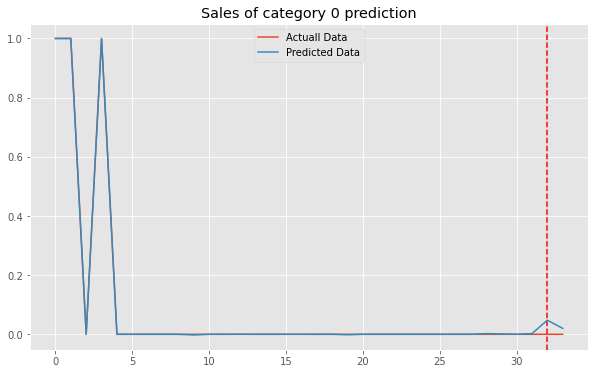

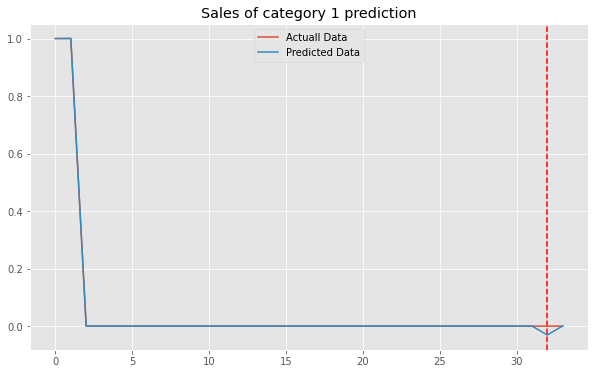

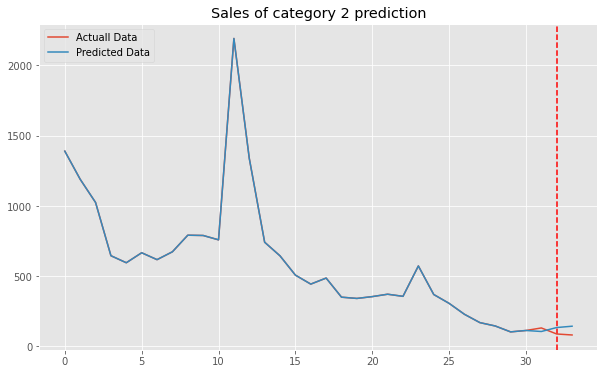

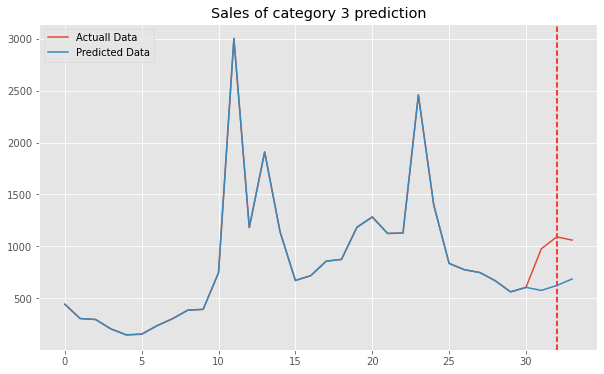

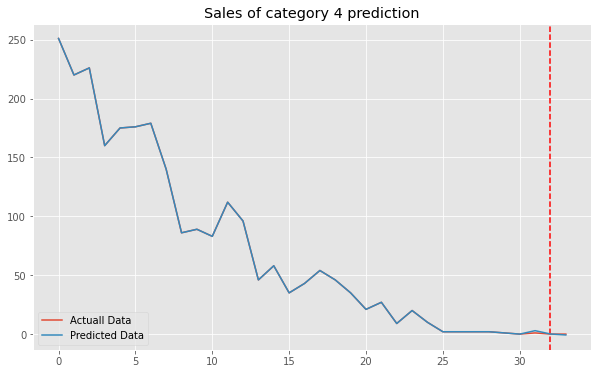

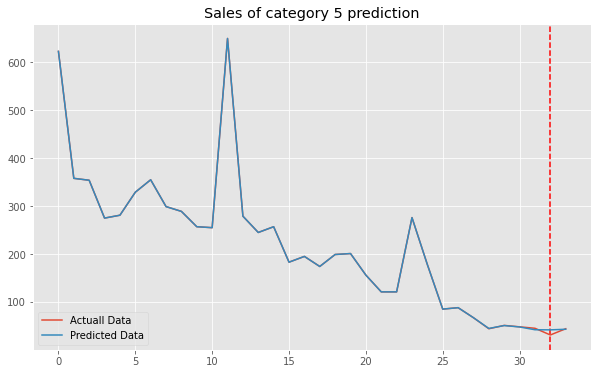

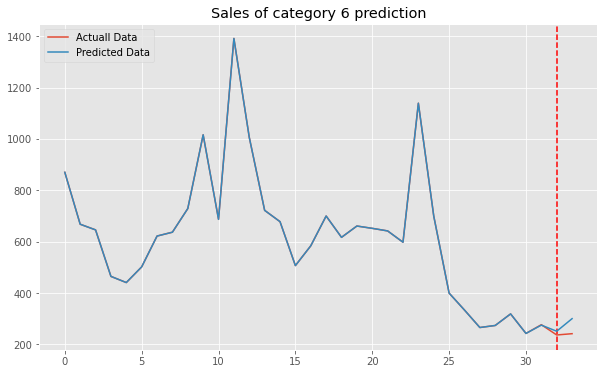

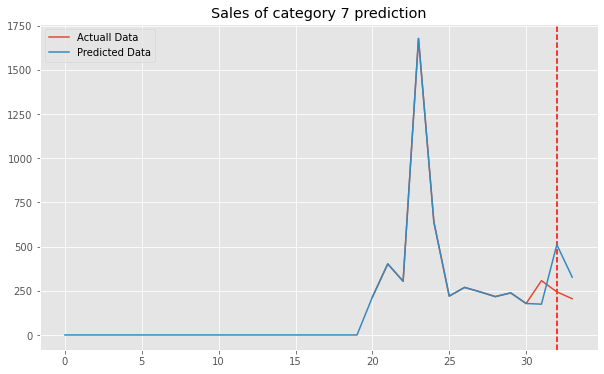

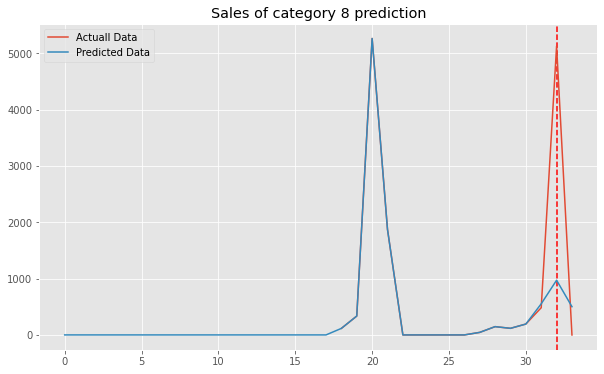

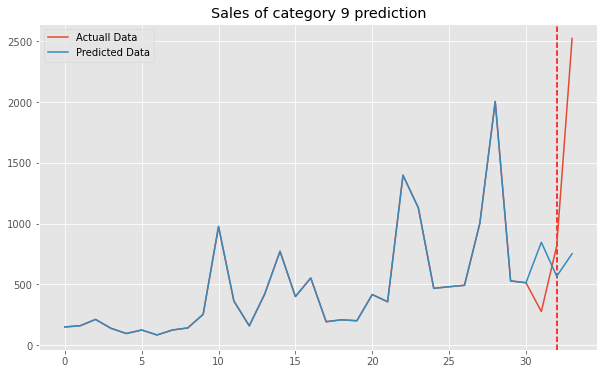

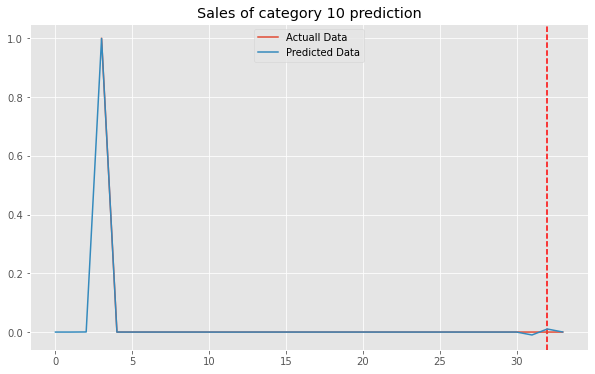

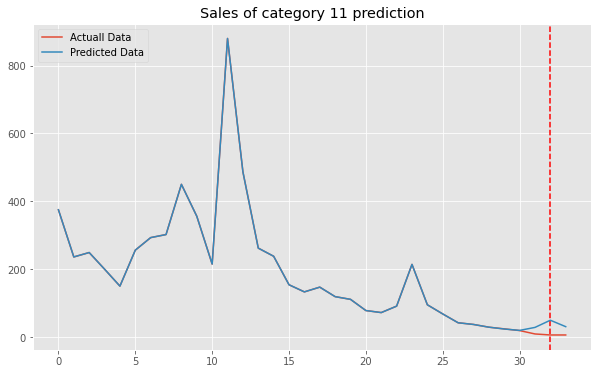

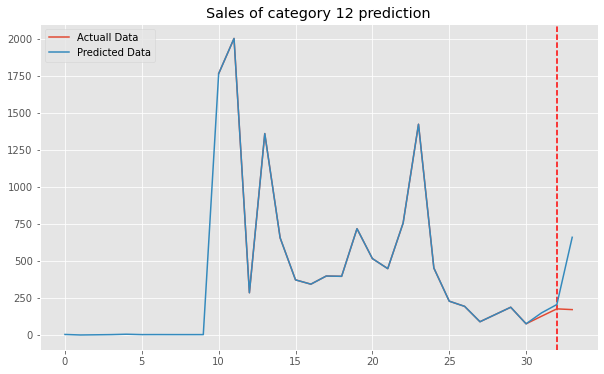

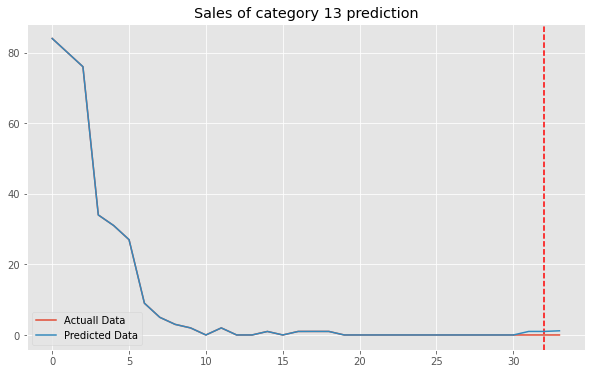

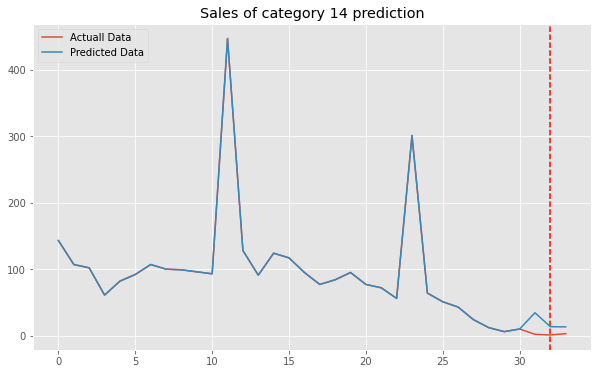

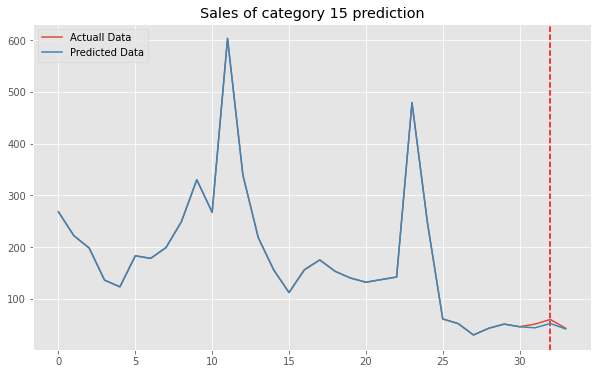

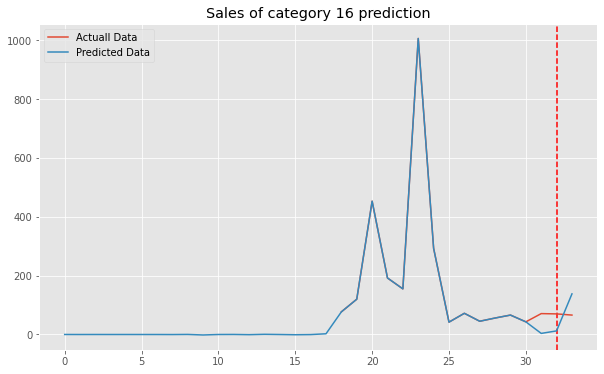

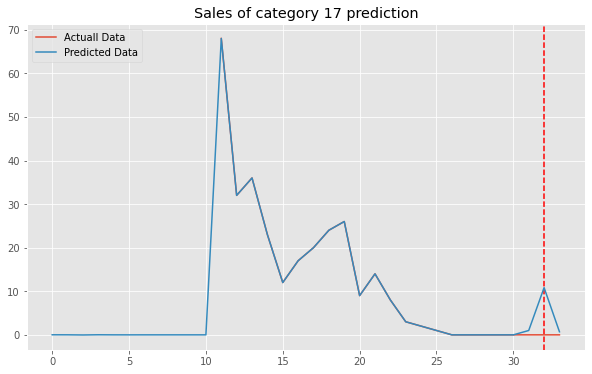

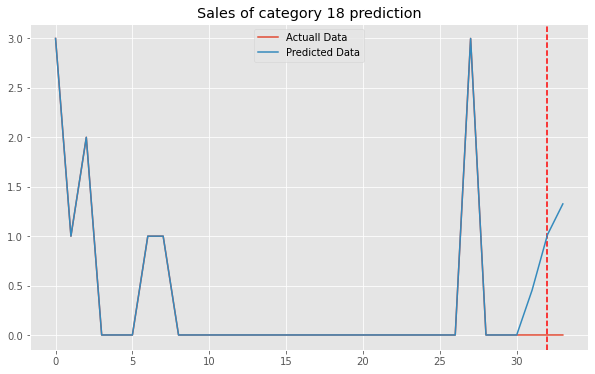

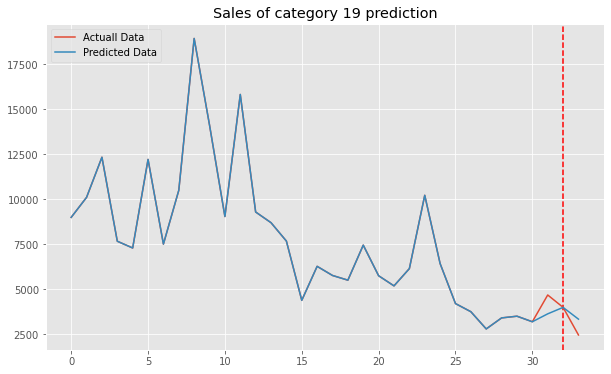

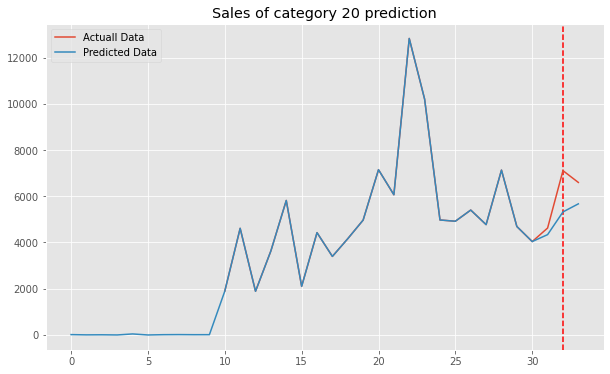

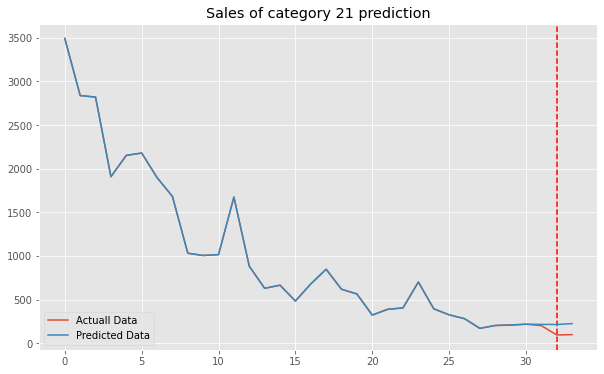

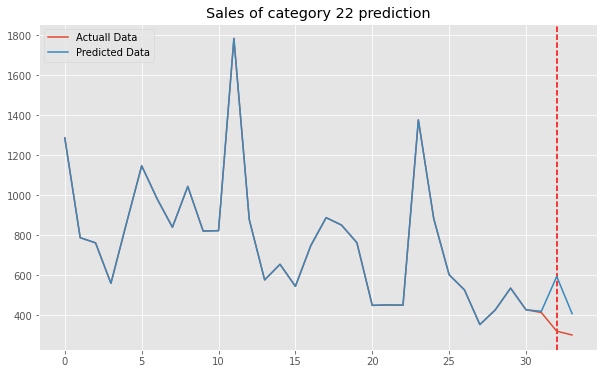

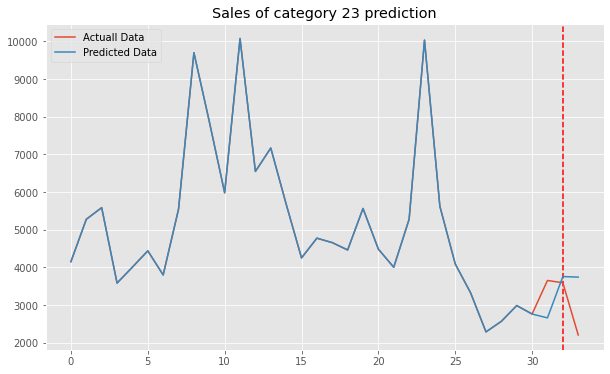

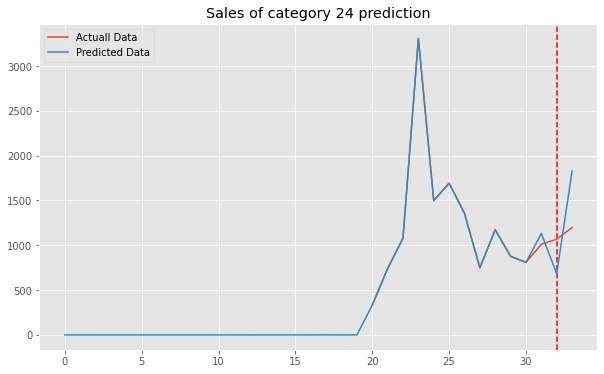

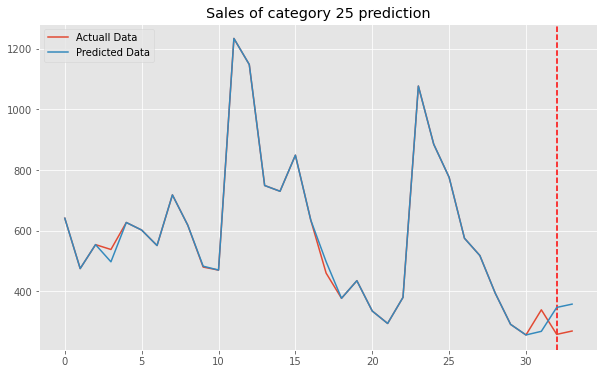

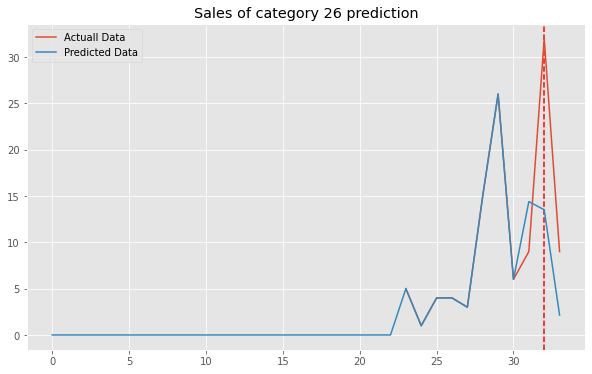

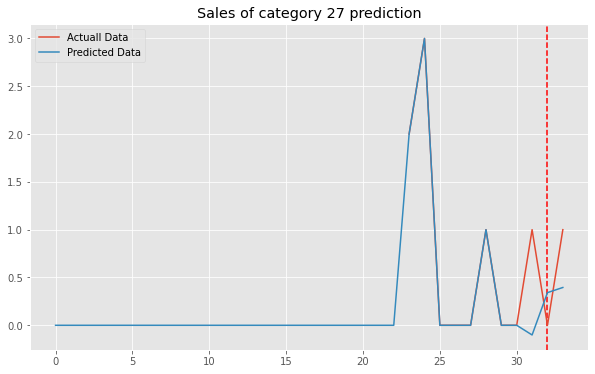

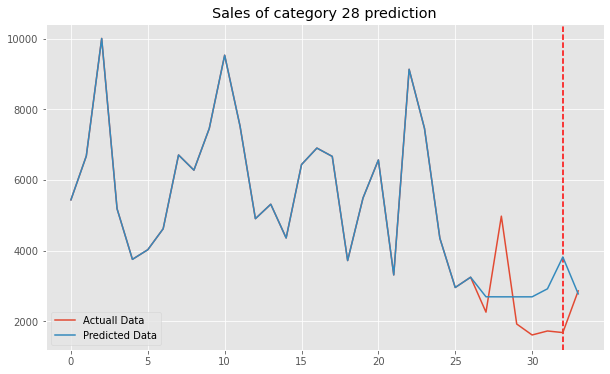

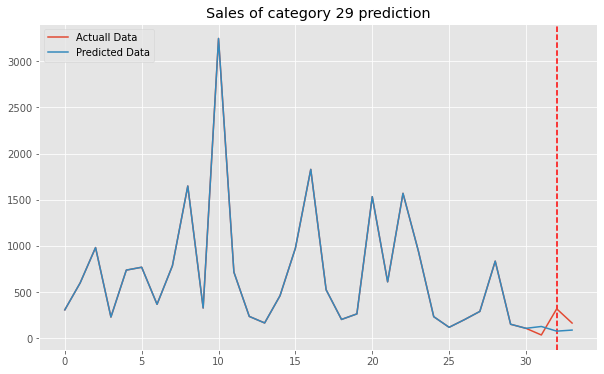

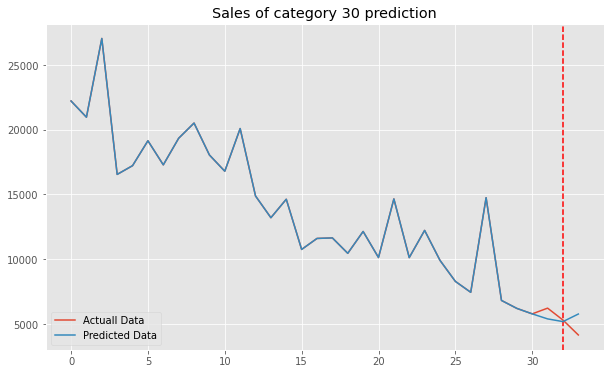

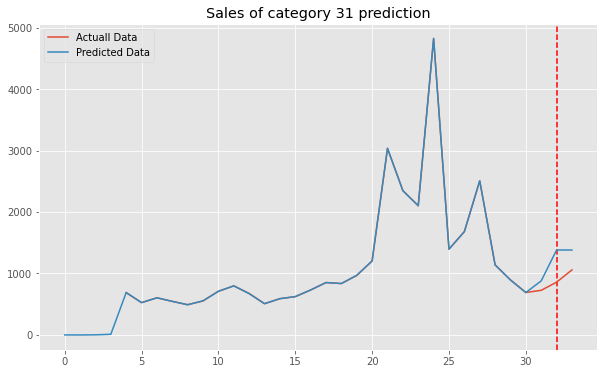

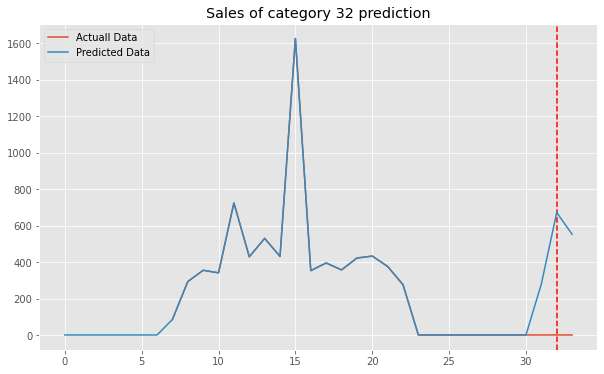

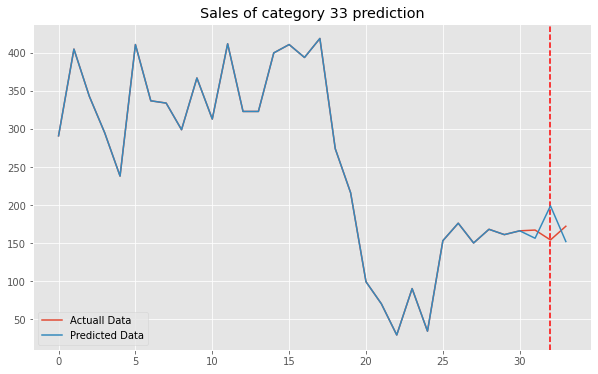

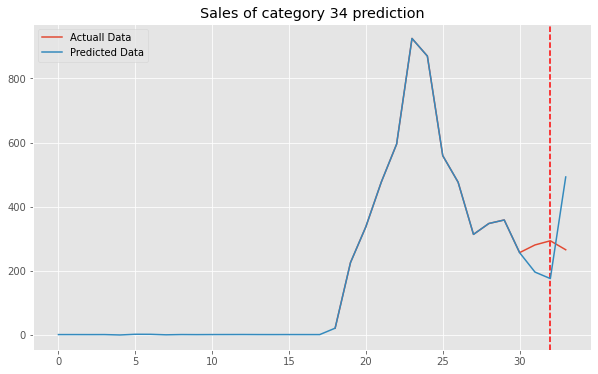

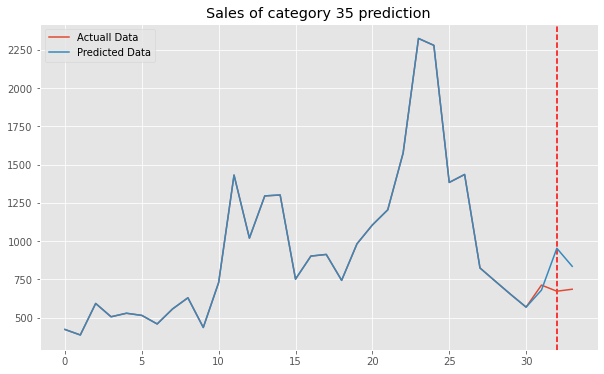

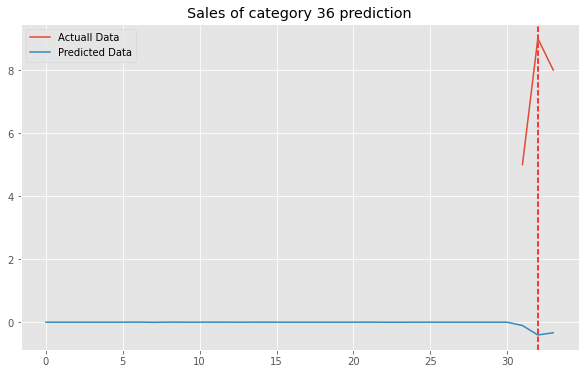

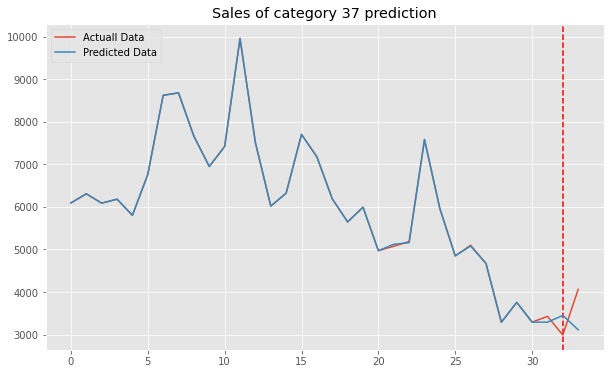

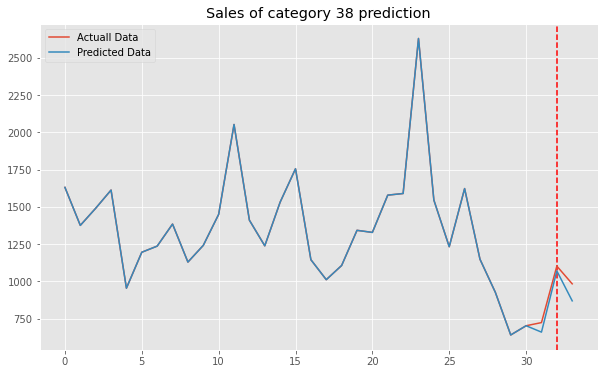

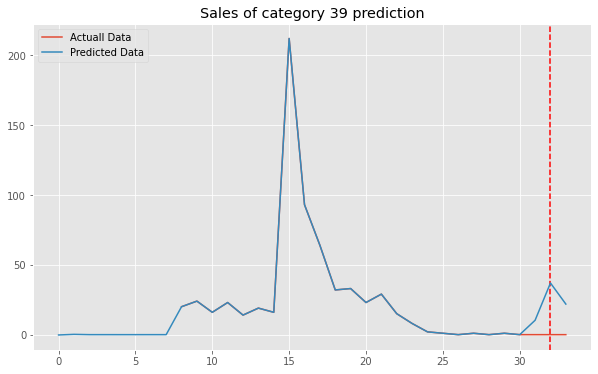

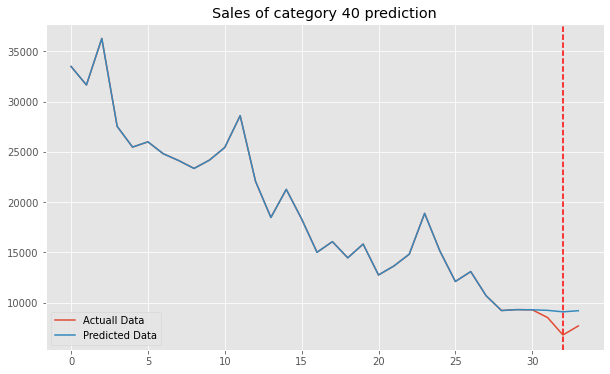

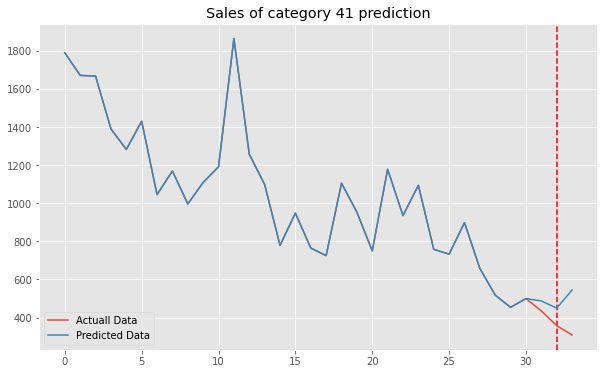

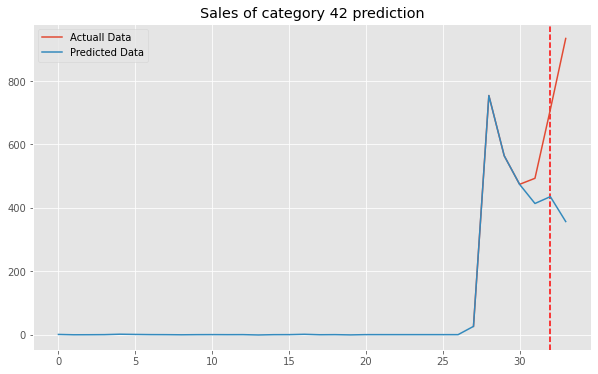

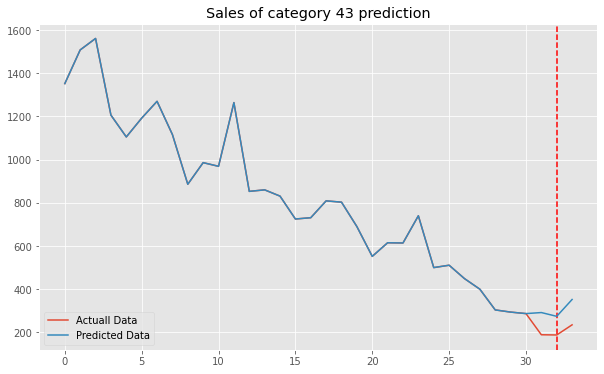

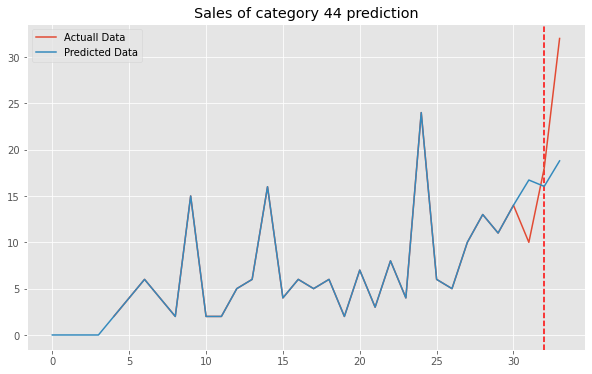

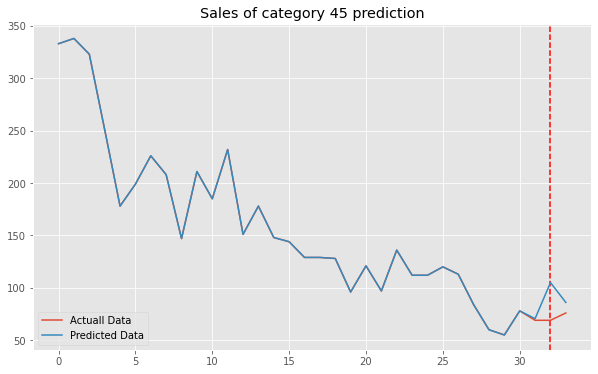

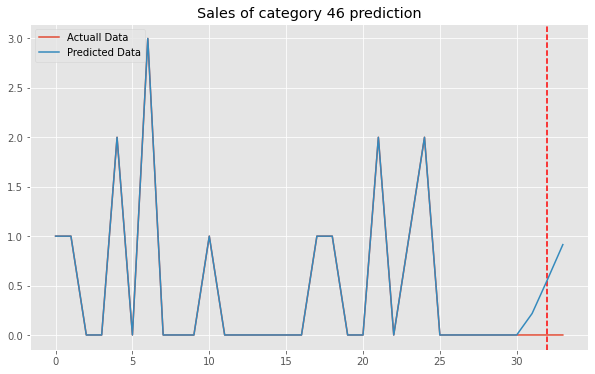

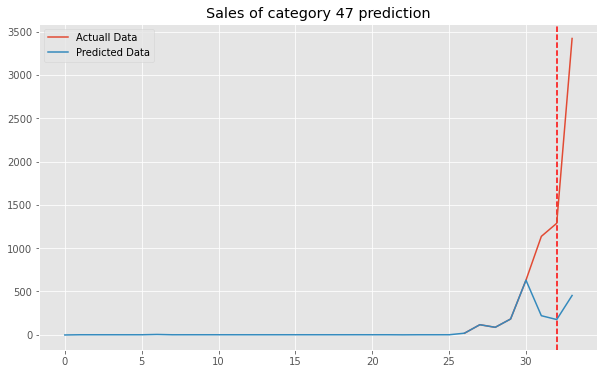

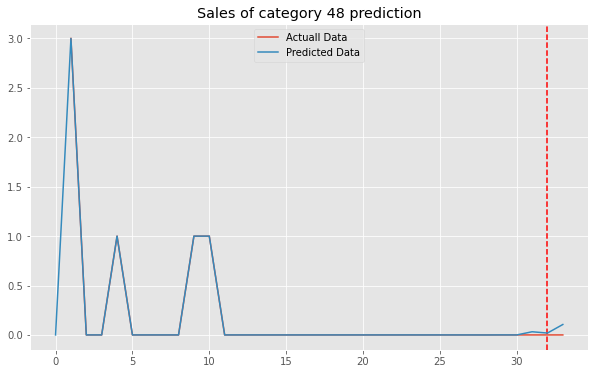

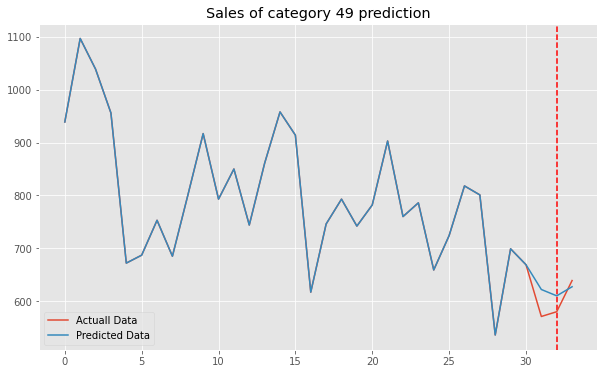

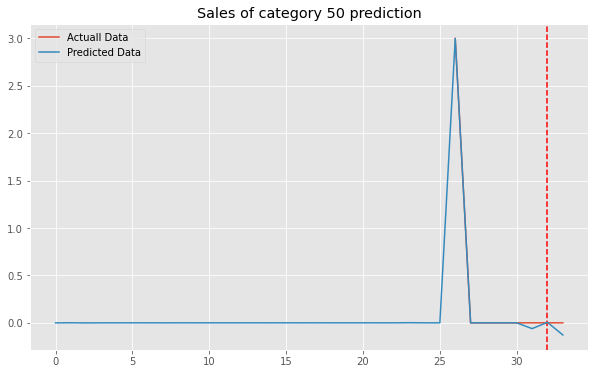

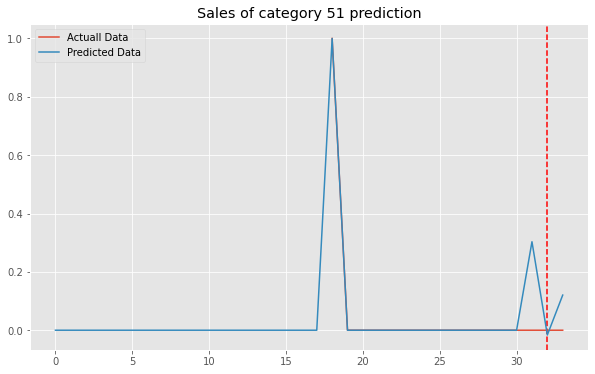

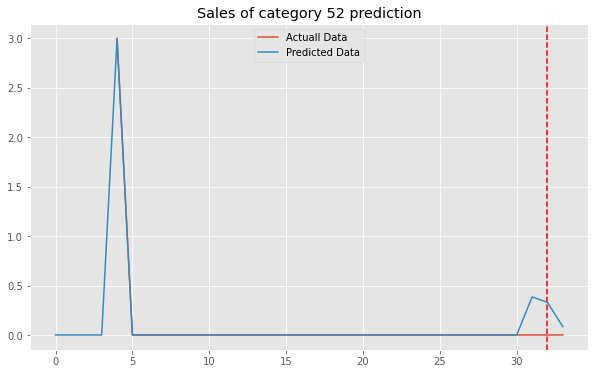

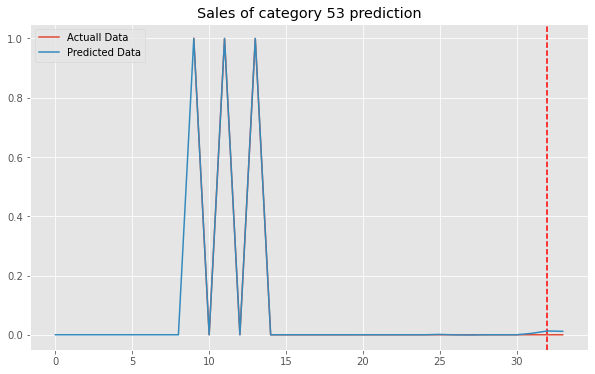

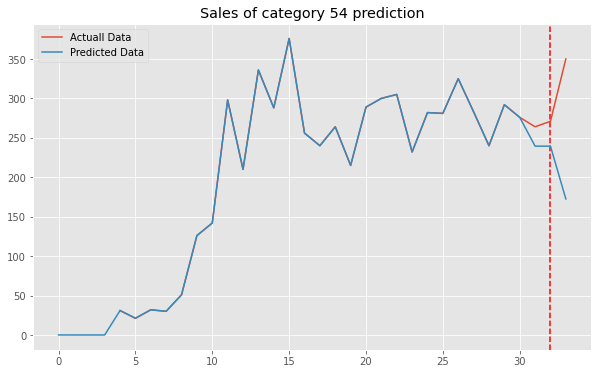

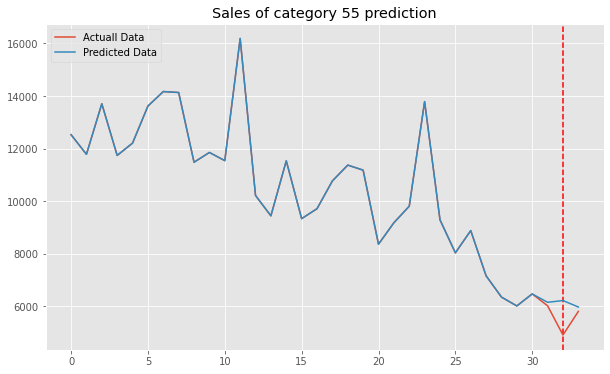

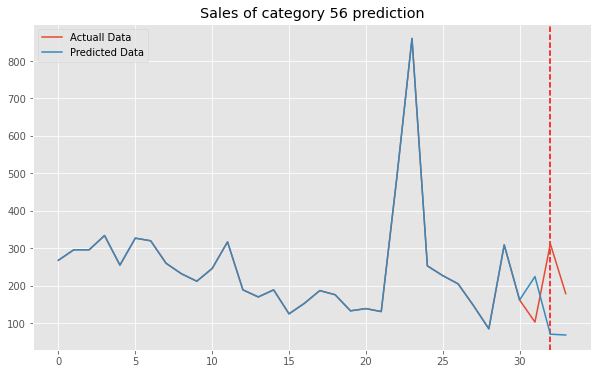

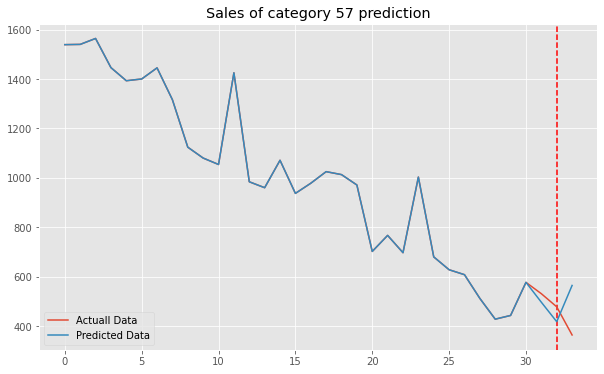

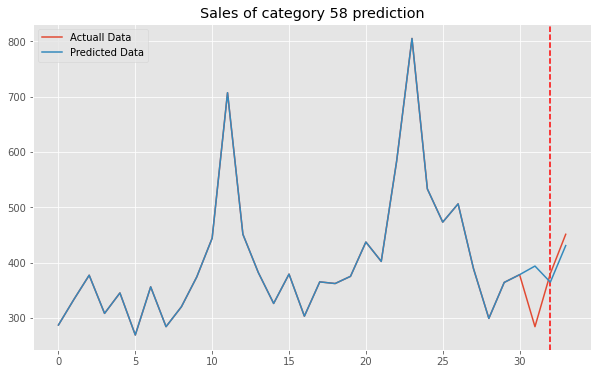

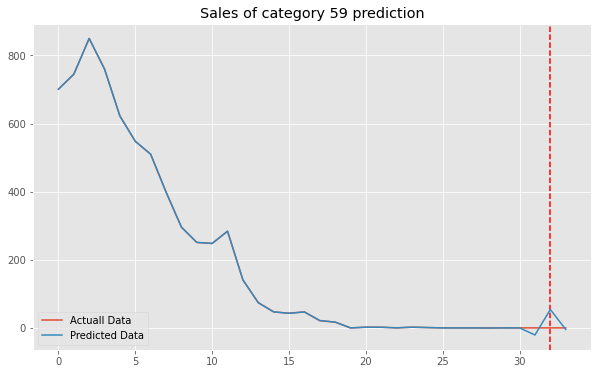

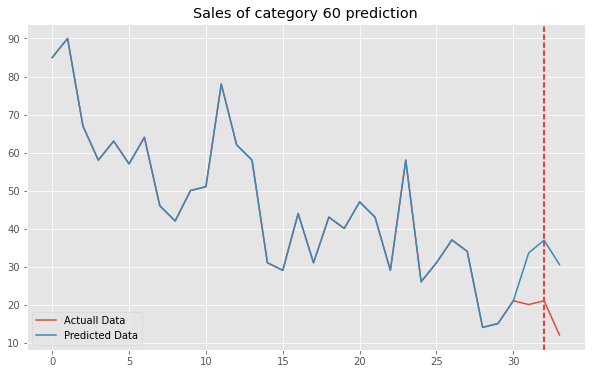

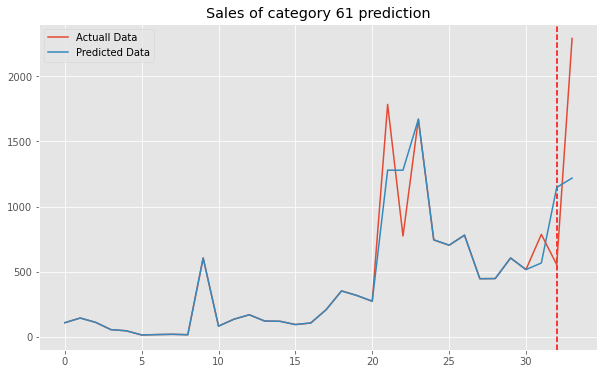

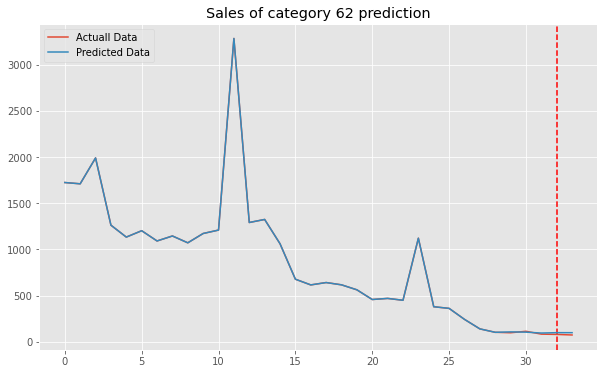

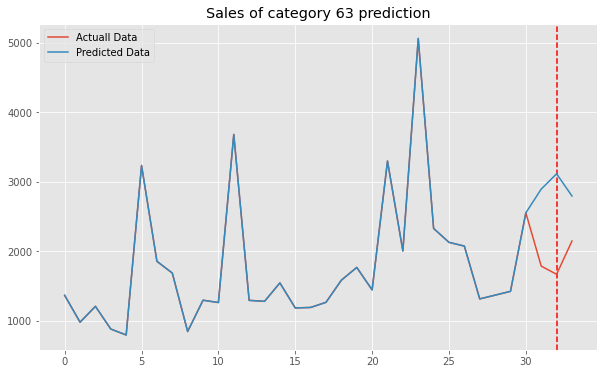

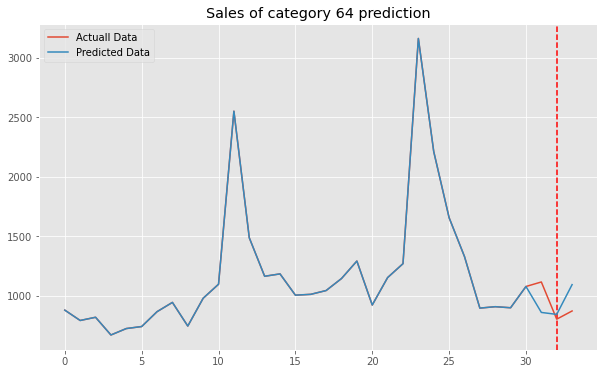

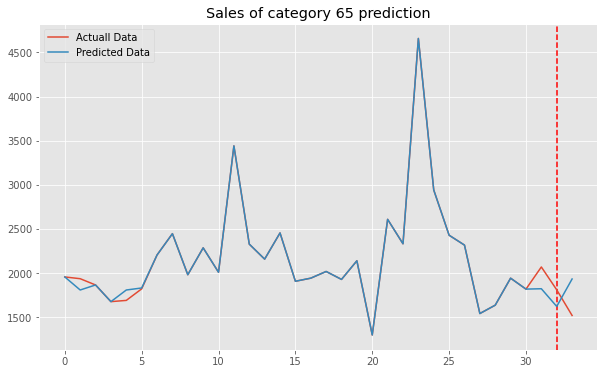

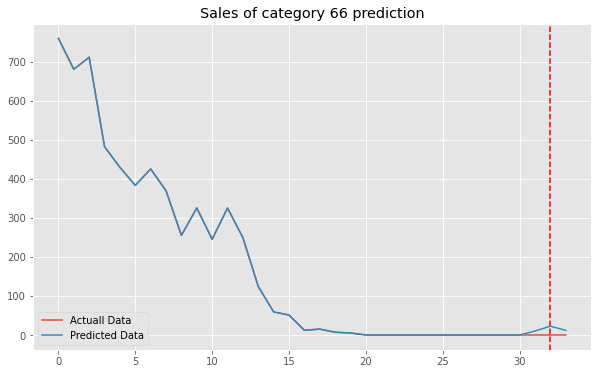

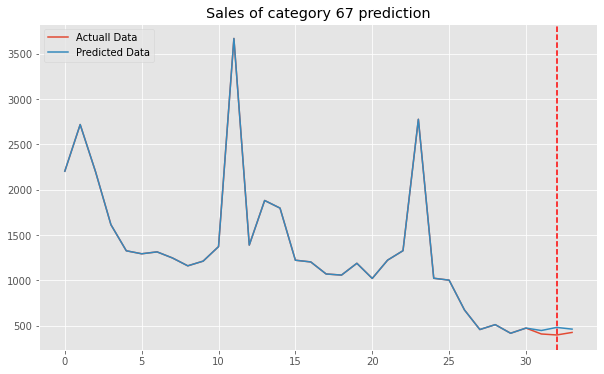

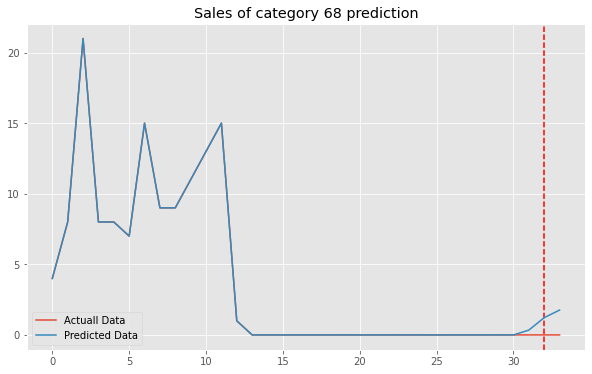

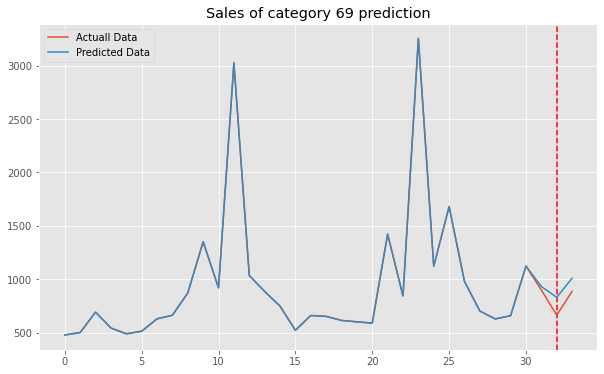

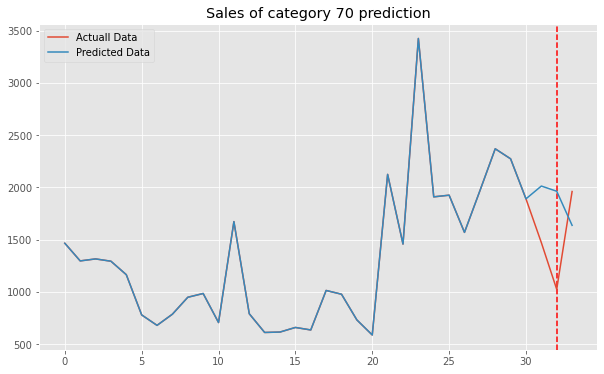

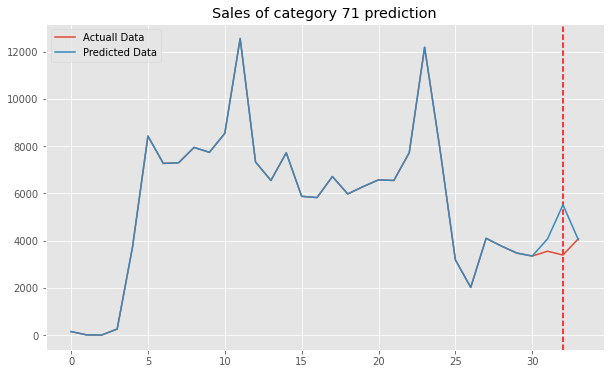

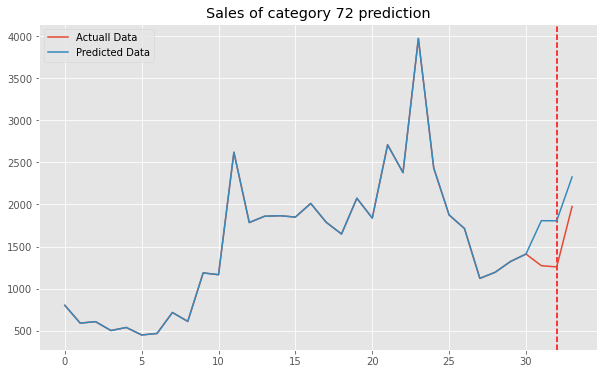

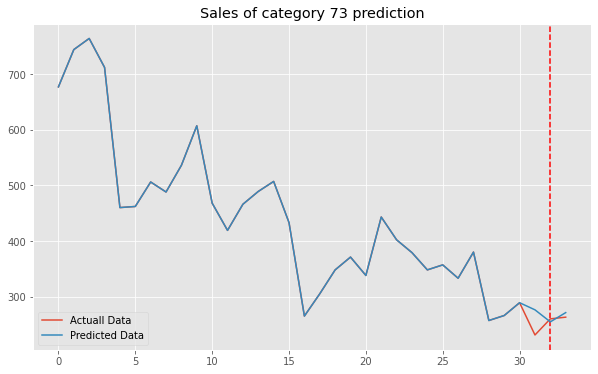

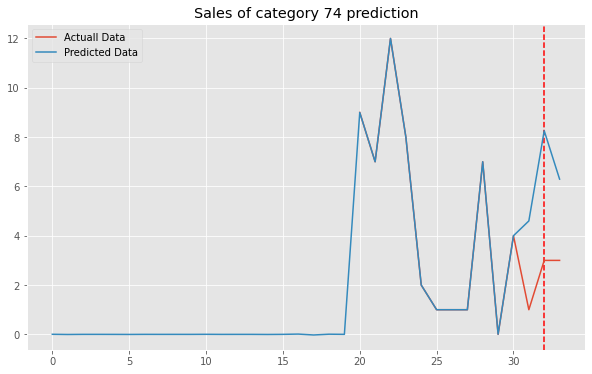

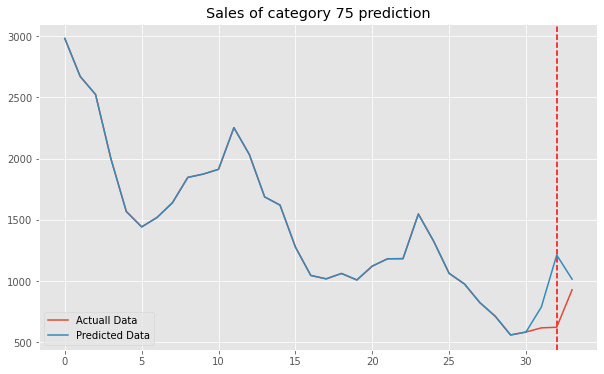

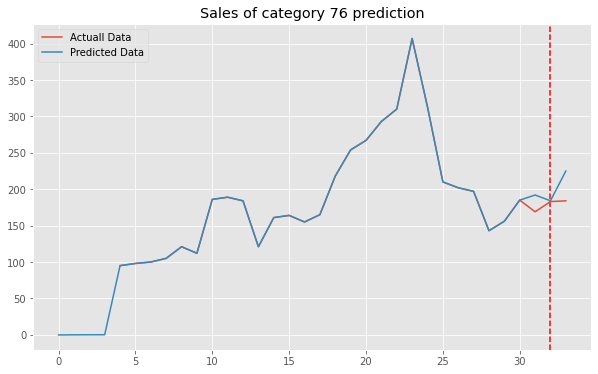

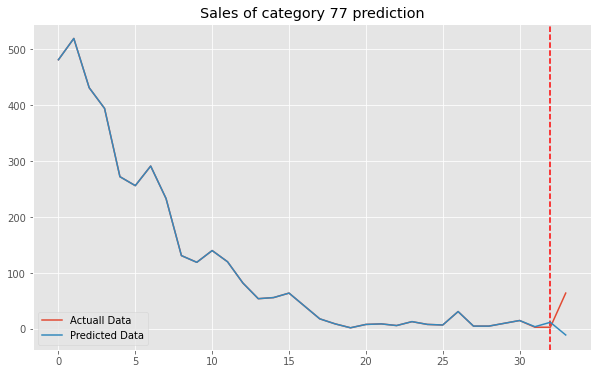

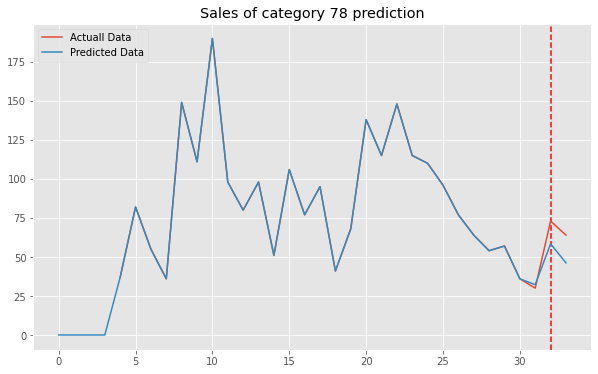

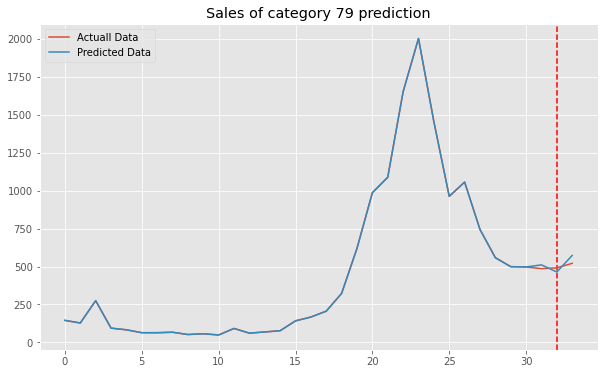

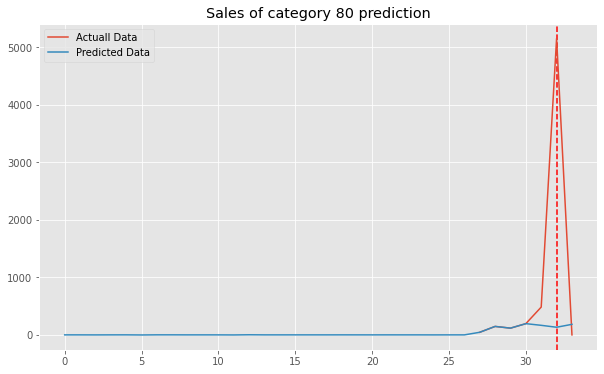

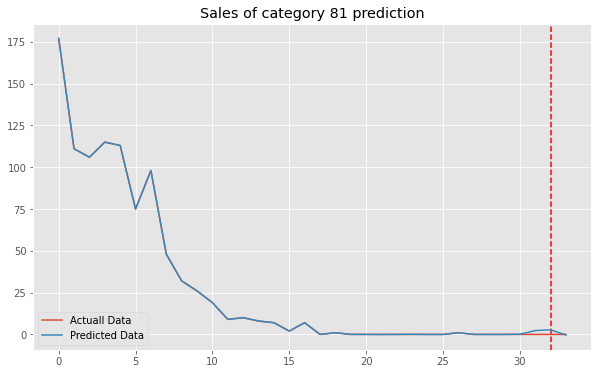

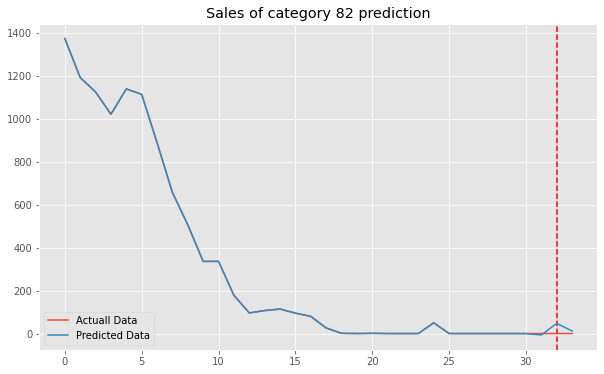

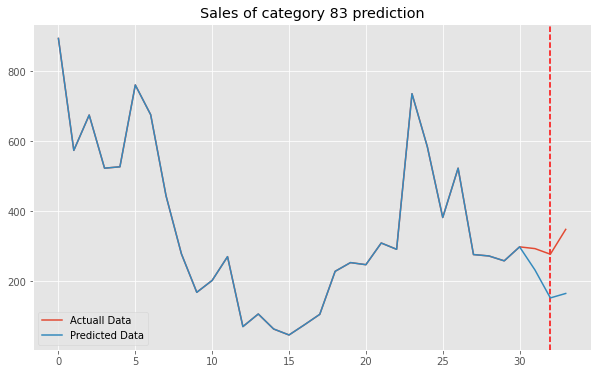

In [319]:
viz_res(df, forecast_02)

# **TRASH AFTER THAT**

In [ ]:
y_mm_train = y_mm[:-4,:]
y_mm_test = y_mm[-4:,:]

X_train = np.array(X.iloc[:-4,:])
X_test = np.array(X.iloc[-4:, :])

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

#y_train_tensors = Variable(torch.Tensor(y_mm_train))
#y_test_tensors = Variable(torch.Tensor(y_mm_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([30, 1, 2]) torch.Size([30, 84])
Testing Shape torch.Size([4, 1, 2]) torch.Size([4, 84])


### Defining the LSTM class

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
    
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0),self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

### Model parameters


In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes
    
    
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class


criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  

In [ ]:
import tqdm as tq

In [ ]:
ss = StandardScaler()

y = ss.fit_transform(mean_price_per_month[:-4:])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [ ]:
y[]

(30, 84)

### Model training

In [ ]:
results_0 = pd.DataFrame()
cat_id = 4

ss = StandardScaler()
y = ss.fit_transform(mean_price_per_month[:-4:])


for epoch in range(num_epochs):
      outputs = lstm1.forward(X_train_tensors_final) #forward pass
      optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  
    # obtain the loss function
      loss = criterion(outputs, Variable(torch.Tensor(y[:,cat_id])))
  
      loss.backward() #calculates the loss of the loss function
  
      optimizer.step() #improve from loss, i.e backprop
      if epoch % 100 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))   


df_X = np.array(X) #old transformers
df_y_test = ss.transform(mean_price_per_month)[:,cat_id] #old transformers

df_X = Variable(torch.Tensor(df_X)) #converting to Tensors
df_y_test = Variable(torch.Tensor(df_y_test))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))    

train_predict = lstm1(df_X)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
results_0[cat_id] = np.concatenate(train_predict.data.numpy().astype(float))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 1.16882
Epoch: 100, loss: 1.00000
Epoch: 200, loss: 1.00000
Epoch: 300, loss: 1.00000
Epoch: 400, loss: 1.00000
Epoch: 500, loss: 1.00000
Epoch: 600, loss: 1.00000
Epoch: 700, loss: 1.00000
Epoch: 800, loss: 1.00000
Epoch: 900, loss: 1.00000


In [ ]:
results_0

4
0  -0.000143
1   0.000006
2   0.000405
3   0.000218
4   0.000063
5   0.000006
6  -0.000014
7  -0.000020
8  -0.000023
9  -0.000023
10 -0.000023
11 -0.000024
12 -0.000024
13 -0.000024
14 -0.000024
15 -0.000024
16 -0.000024
17 -0.000024
18 -0.000024
19 -0.000024
20 -0.000024
21 -0.000024
22 -0.000024
23 -0.000024
24 -0.000024
25 -0.000024
26 -0.000024
27 -0.000024
28 -0.000024
29 -0.000024
30 -0.000024
31 -0.000024
32 -0.000024
33 -0.000024

In [ ]:
y[:,cat_id]

array([ 2.73222009,  2.18728662,  1.73645478,  1.14814526,  1.07550064,
        0.99688957,  0.5198835 ,  0.39987556,  0.43897035,  0.42701531,
       -0.04761556,  0.05999591,  0.01208073, -0.30639911, -0.39296088,
       -0.52153869, -0.48133173, -0.44680019, -0.45654631, -0.48417897,
       -0.44000127, -0.4299401 , -0.4299401 , -0.61397571, -0.55838773,
       -0.7812427 , -1.48300946, -1.2868166 , -1.41258125, -1.16105195])

In [ ]:
results = pd.DataFrame()
for cat_id in tq.tqdm(list(df.columns)):
  for epoch in range(num_epochs):
      outputs = lstm1.forward(X_train_tensors_final) #forward pass
      optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  
    # obtain the loss function
      loss = criterion(outputs, Variable(torch.Tensor(y_mm_train[:,cat_id])))
  
      loss.backward() #calculates the loss of the loss function
  
      optimizer.step() #improve from loss, i.e backprop
      #if epoch % 100 == 0:
          #print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))   


      df_X = np.array(X) #old transformers
      df_y_mm = mm.transform(y_mm)[:,cat_id] #old transformers

      df_X = Variable(torch.Tensor(df_X)) #converting to Tensors
      df_y_mm = Variable(torch.Tensor(df_y_mm))
      #reshaping the dataset
      df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))    

      train_predict = lstm1(df_X)#forward pass
      data_predict = train_predict.data.numpy() #numpy conversion
      results[cat_id] = np.concatenate(train_predict.data.numpy().astype(float))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broa

In [ ]:
results

0   1   2   3   4   5   6   7   8   9   ...  74  75  76  77  78  79  80  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
17 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
18 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
19 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
20 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
21 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
22 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
23 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
24 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
26 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
27 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
28 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
29 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
31 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
32 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
33 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   

    81  82  83  
0  NaN NaN NaN  
1  NaN NaN NaN  
2  NaN NaN NaN  
3  NaN NaN NaN  
4  NaN NaN NaN  
5  NaN NaN NaN  
6  NaN NaN NaN  
7  NaN NaN NaN  
8  NaN NaN NaN  
9  NaN NaN NaN  
10 NaN NaN NaN  
11 NaN NaN NaN  
12 NaN NaN NaN  
13 NaN NaN NaN  
14 NaN NaN NaN  
15 NaN NaN NaN  
16 NaN NaN NaN  
17 NaN NaN NaN  
18 NaN NaN NaN  
19 NaN NaN NaN  
20 NaN NaN NaN  
21 NaN NaN NaN  
22 NaN NaN NaN  
23 NaN NaN NaN  
24 NaN NaN NaN  
25 NaN NaN NaN  
26 NaN NaN NaN  
27 NaN NaN NaN  
28 NaN NaN NaN  
29 NaN NaN NaN  
30 NaN NaN NaN  
31 NaN NaN NaN  
32 NaN NaN NaN  
33 NaN NaN NaN  

[34 rows x 84 columns]